<head>
    <br>
    <h1 style="text-align:center"><Strong>Cleaning and analysis of crime and arrest data in NYC with training of Machine Learning model for the prediction of future offenses.</strong></h1>
    <h3 style="text-align:center"> Ing. Alejandro Silva Ramírez</h3>
    <br><br><br>
    <p style="text-align:center;font-size:13px">In this project, a large database is analyzed with data on the latest arrests in NYC according to localities and police reports, as well as characteristics of the offense and the offender, which allow important information to be extracted about their characteristics. and train a Machine Learning model to predict future offenses. </p>
    <br><br>
</head>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import missingno as msno
import seaborn as sns
import operator
import datetime
import folium
from folium.plugins import HeatMap
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

!pip install --quiet optuna
import optuna

# Montar Drive:
drive.mount("/content/gdrive")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00
Mounted at /content/gdrive


# Importar datos de Drive:

In [ ]:
# Importar datos:
df_2018_2022 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Proyecto_Final_Forense/Crimes_2018_2022.csv")
df_2023 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Proyecto_Final_Forense/Crimes_2023.csv")

# Datos en 3 cifras significativas:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Ver tabla 2018-2022:
df_2018_2022.head()

ARREST_KEY ARREST_DATE   PD_CD                                     PD_DESC  \
0   173151631  01/02/2018 205.000                        TRESPASS 2, CRIMINAL   
1   173188566  01/02/2018 101.000                                   ASSAULT 3   
2   173175365  01/02/2018 101.000                                   ASSAULT 3   
3   173169664  01/02/2018 139.000                         MURDER,UNCLASSIFIED   
4   173163856  01/02/2018 339.000  LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED   

    KY_CD                        OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
0 352.000                CRIMINAL TRESPASS  PL 1401500          M           M   
1 344.000     ASSAULT 3 & RELATED OFFENSES  PL 1200001          M           K   
2 344.000     ASSAULT 3 & RELATED OFFENSES  PL 1200001          M           M   
3 101.000  MURDER & NON-NEGL. MANSLAUGHTER  PL 1252501          F           B   
4 341.000                    PETIT LARCENY  PL 1552500          M           M   

   ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD Latitude Longitude  \
0               28  ...      997875     230878   40.800   -73.951   
1               67  ...      997897     175677   40.649   -73.951   
2               14  ...      988191     215312   40.758   -73.986   
3               42  ...     1008691     238872   40.822   -73.912   
4               14  ...      986781     212761   40.751   -73.991   

                                         Lon_Lat  Zip Codes  \
0   POINT (-73.95078943299995 40.80038048100005)  12423.000   
1   POINT (-73.95082189999994 40.64886713300007)  13510.000   
2   POINT (-73.98577611499996 40.75766554000006)  13094.000   
3   POINT (-73.91169413099993 40.82229848500003)  10929.000   
4  POINT (-73.99086657499998 40.750664208000046)  11722.000   

   Community Districts  Borough Boundaries City Council Districts  \
0               18.000               4.000                 36.000   
1               61.000               2.000                 11.000   
2               11.000               4.000                 10.000   
3               34.000               5.000                 43.000   
4               11.000               4.000                 10.000   

   Police Precincts  
0            18.000  
1            40.000  
2             8.000  
3            25.000  
4             8.000  

[5 rows x 24 columns]

In [ ]:
# Ver tabla 2023:
df_2023.head()

ARREST_KEY ARREST_DATE   PD_CD                         PD_DESC   KY_CD  \
0   263187871  02/07/2023 105.000               STRANGULATION 1ST 106.000   
1   261368273  01/04/2023     NaN                          (null)     NaN   
2   261667175  01/10/2023 101.000                       ASSAULT 3 344.000   
3   264298625  02/27/2023     NaN                          (null)     NaN   
4   261516485  01/07/2023 397.000  ROBBERY,OPEN AREA UNCLASSIFIED 105.000   

                      OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
0                FELONY ASSAULT  PL 1211200          F           S   
1                        (null)  RPA0076801          M           M   
2  ASSAULT 3 & RELATED OFFENSES  PL 1200001          M           B   
3                        (null)  PL 2224000          F           Q   
4                       ROBBERY  PL 1601001          F           M   

   ARREST_PRECINCT  JURISDICTION_CODE AGE_GROUP PERP_SEX       PERP_RACE  \
0              120                  0     25-44        M           BLACK   
1               34                  0     25-44        F           BLACK   
2               42                  0     18-24        F  WHITE HISPANIC   
3              113                  0     25-44        M           BLACK   
4               18                  0       <18        M           BLACK   

   X_COORD_CD  Y_COORD_CD  Latitude  Longitude  \
0      951637      171141    40.636    -74.118   
1     1004287      251338    40.857    -73.928   
2     1008754      238895    40.822    -73.911   
3     1039225      181937    40.666    -73.802   
4      988210      218129    40.765    -73.986   

           New Georeferenced Column  
0      POINT (-74.117505 40.636362)  
1      POINT (-73.927564 40.856519)  
2      POINT (-73.911463 40.822355)  
3  POINT (-73.80183654 40.66588105)  
4       POINT (-73.985702 40.76539)

# Tamaño inicial de los archivos:

In [ ]:
print("Tamaño 2018-2022: ", df_2018_2022.shape)
print("Tamaño 2023:      ", df_2023.shape)

Tamaño 2018-2022:  (946631, 24)
Tamaño 2023:       (54576, 19)


# Información básica de los datos:

In [ ]:
df_2018_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946631 entries, 0 to 946630
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ARREST_KEY              946631 non-null  int64  
 1   ARREST_DATE             946631 non-null  object 
 2   PD_CD                   945908 non-null  float64
 3   PD_DESC                 945407 non-null  object 
 4   KY_CD                   944837 non-null  float64
 5   OFNS_DESC               945407 non-null  object 
 6   LAW_CODE                946586 non-null  object 
 7   LAW_CAT_CD              939038 non-null  object 
 8   ARREST_BORO             946631 non-null  object 
 9   ARREST_PRECINCT         946631 non-null  int64  
 10  JURISDICTION_CODE       946631 non-null  int64  
 11  AGE_GROUP               946631 non-null  object 
 12  PERP_SEX                946631 non-null  object 
 13  PERP_RACE               946631 non-null  object 
 14  X_COORD_CD          

In [ ]:
df_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54576 entries, 0 to 54575
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ARREST_KEY                54576 non-null  int64  
 1   ARREST_DATE               54576 non-null  object 
 2   PD_CD                     54325 non-null  float64
 3   PD_DESC                   54576 non-null  object 
 4   KY_CD                     54325 non-null  float64
 5   OFNS_DESC                 54576 non-null  object 
 6   LAW_CODE                  54576 non-null  object 
 7   LAW_CAT_CD                54156 non-null  object 
 8   ARREST_BORO               54576 non-null  object 
 9   ARREST_PRECINCT           54576 non-null  int64  
 10  JURISDICTION_CODE         54576 non-null  int64  
 11  AGE_GROUP                 54576 non-null  object 
 12  PERP_SEX                  54576 non-null  object 
 13  PERP_RACE                 54576 non-null  object 
 14  X_COOR

# Valores faltantes:

## Porcentajes faltantes iniciales:

In [ ]:
(df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"})

Porcentaje[%]
ARREST_KEY                      0.000
ARREST_DATE                     0.000
PD_CD                           0.076
PD_DESC                         0.129
KY_CD                           0.190
OFNS_DESC                       0.129
LAW_CODE                        0.005
LAW_CAT_CD                      0.802
ARREST_BORO                     0.000
ARREST_PRECINCT                 0.000
JURISDICTION_CODE               0.000
AGE_GROUP                       0.000
PERP_SEX                        0.000
PERP_RACE                       0.000
X_COORD_CD                      0.000
Y_COORD_CD                      0.000
Latitude                        0.000
Longitude                       0.000
Lon_Lat                         0.000
Zip Codes                       0.221
Community Districts             0.013
Borough Boundaries              0.014
City Council Districts          0.013
Police Precincts                0.013

In [ ]:
(df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"})

Porcentaje[%]
ARREST_KEY                        0.000
ARREST_DATE                       0.000
PD_CD                             0.460
PD_DESC                           0.000
KY_CD                             0.460
OFNS_DESC                         0.000
LAW_CODE                          0.000
LAW_CAT_CD                        0.770
ARREST_BORO                       0.000
ARREST_PRECINCT                   0.000
JURISDICTION_CODE                 0.000
AGE_GROUP                         0.000
PERP_SEX                          0.000
PERP_RACE                         0.000
X_COORD_CD                        0.000
Y_COORD_CD                        0.000
Latitude                          0.000
Longitude                         0.000
New Georeferenced Column          0.000

##Funciones:

In [ ]:
def list_cod(completar, usando):
  # Lista de códigos "completar" basado en los "usando" (2018 - 2022):
  list_1822 = df_2018_2022
  list_1822 = list_1822.dropna(subset = usando)
  list_1822 = list_1822.dropna(subset = completar)
  list_1822 = list_1822.drop_duplicates(subset = usando)
  list_1822 = list_1822[[usando, completar]]
  list_1822 = dict(list_1822.values)
  # Lista de códigos "completar" basado en los "usando" (2023):
  list_23 = df_2023
  list_23 = list_23.dropna(subset = usando)
  list_23 = list_23.drop_duplicates(subset = usando)
  list_23 = list_23.drop_duplicates(subset = completar)
  list_23 = list_23[[usando, completar]]
  list_23 = dict(list_23.values)
  # Unificar ambos códigos:
  list_final = list_1822
  list_final.update(list_23)

  print(list_final.items())
  return list_final

## [PASO 1] Completar códigos "LAW_CAT_CD" utilizando los datos de "PD_DC", "KY_CD", "LAW_CODE", "PD_DESC" y "OFNS_DESC":

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("LAW_CAT_CD", "PD_CD")
list_KY_CD = list_cod("LAW_CAT_CD", "KY_CD")
list_LAW_CODE = list_cod("LAW_CAT_CD", "LAW_CODE")
list_PD_DESC = list_cod("LAW_CAT_CD", "PD_DESC")
list_OFNS_DESC = list_cod("LAW_CAT_CD", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.PD_CD.map(list_PD_CD))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.KY_CD.map(list_KY_CD))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.PD_CD.map(list_PD_CD))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.KY_CD.map(list_KY_CD))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.PD_DESC.map(list_PD_DESC))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(205.0, 'M'), (101.0, 'M'), (139.0, 'F'), (339.0, 'M'), (922.0, 'M'), (567.0, 'M'), (113.0, 'M'), (566.0, 'V'), (109.0, 'F'), (729.0, 'F'), (269.0, 'F'), (494.0, 'F'), (918.0, 'M'), (847.0, 'F'), (439.0, 'F'), (793.0, 'F'), (511.0, 'M'), (203.0, 'M'), (397.0, 'F'), (639.0, 'M'), (681.0, 'M'), (419.0, 'F'), (905.0, 'M'), (105.0, 'F'), (508.0, 'M'), (478.0, 'M'), (569.0, 'M'), (462.0, 'M'), (705.0, 'M'), (244.0, 'F'), (115.0, 'M'), (515.0, 'F'), (779.0, 'F'), (114.0, 'M'), (112.0, 'F'), (969.0, 'M'), (688.0, 'M'), (748.0, 'M'), (792.0, 'F'), (273.0, 'F'), (760.0, 'F'), (563.0, 'M'), (106.0, 'F'), (157.0, 'F'), (661.0, 'M'), (744.0, 'M'), (258.0, 'M'), (259.0, 'M'), (117.0, 'F'), (916.0, 'F'), (782.0, 'M'), (848.0, 'M'), (503.0, 'F'), (640.0, 'F'), (766.0, 'F'), (153.0, 'F'), (785.0, 'M'), (475.0, 'M'), (750.0, 'M'), (812.0, 'M'), (724.0, 'F'), (968.0, 'I'), (764.0, 'F'), (501.0, 'F'), (507.0, 'F'), (904.0, 'F'), (505.0, 'F'), (849.0, 'V'), (175.0, 'M'), (168.0, 'F'), (510.0, 

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.076                    0.076
PD_DESC                    0.129                    0.129
KY_CD                      0.190                    0.190
OFNS_DESC                  0.129                    0.129
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.460                    0.460
PD_DESC                    0.000                    0.000
KY_CD                      0.460                    0.460
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

## [PASO 2] Completar códigos "KY_CD" utilizando los datos de "PD_DC", "LAW_CODE", "LAW_CAT_CD", "PD_DESC" y "OFNS_DESC":

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("KY_CD", "PD_CD")
list_LAW_CODE = list_cod("KY_CD", "LAW_CODE")
list_LAW_CAT_CD = list_cod("KY_CD", "LAW_CAT_CD")
list_PD_DESC = list_cod("KY_CD", "PD_DESC")
list_OFNS_DESC = list_cod("KY_CD", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.PD_CD.map(list_PD_CD))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.PD_CD.map(list_PD_CD))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.PD_DESC.map(list_PD_DESC))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(205.0, 352.0), (101.0, 344.0), (139.0, 101.0), (339.0, 341.0), (922.0, 348.0), (567.0, 235.0), (113.0, 344.0), (566.0, 678.0), (109.0, 106.0), (729.0, 113.0), (269.0, 121.0), (494.0, 111.0), (918.0, 348.0), (847.0, 125.0), (439.0, 109.0), (793.0, 118.0), (511.0, 235.0), (203.0, 352.0), (397.0, 105.0), (639.0, 361.0), (681.0, 233.0), (419.0, 109.0), (905.0, 347.0), (105.0, 106.0), (508.0, 235.0), (478.0, 343.0), (569.0, 235.0), (462.0, 353.0), (705.0, 358.0), (244.0, 107.0), (115.0, 355.0), (515.0, 117.0), (779.0, 126.0), (114.0, 344.0), (112.0, 126.0), (969.0, 881.0), (688.0, 345.0), (748.0, 359.0), (792.0, 118.0), (273.0, 121.0), (760.0, 126.0), (563.0, 356.0), (106.0, 106.0), (157.0, 104.0), (661.0, 361.0), (744.0, 359.0), (258.0, 351.0), (259.0, 351.0), (117.0, 126.0), (916.0, 348.0), (782.0, 236.0), (848.0, 364.0), (503.0, 117.0), (640.0, 126.0), (766.0, 126.0), (153.0, 104.0), (785.0, 236.0), (750.0, 359.0), (812.0, 364.0), (724.0, 126.0), (968.0, 880.0), (764.0, 126.

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.076                    0.076
PD_DESC                    0.129                    0.129
KY_CD                      0.018                    0.190
OFNS_DESC                  0.129                    0.129
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.460                    0.460
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.460
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

## [PASO 3] Completar códigos "PD_DESC" utilizando los datos de "PD_DC", "KY_CD", "LAW_CODE", "LAW_CAT_CD" y "OFNS_DESC":

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("PD_DESC", "PD_CD")
list_KY_CD = list_cod("PD_DESC", "KY_CD")
list_LAW_CODE = list_cod("PD_DESC", "LAW_CODE")
list_LAW_CAT_CD = list_cod("PD_DESC", "LAW_CAT_CD")
list_OFNS_DESC = list_cod("PD_DESC", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.PD_DESC = df_2018_2022.PD_DESC.fillna(df_2018_2022.PD_CD.map(list_PD_CD))
df_2018_2022.PD_DESC = df_2018_2022.PD_DESC.fillna(df_2018_2022.KY_CD.map(list_KY_CD))
df_2018_2022.PD_DESC = df_2018_2022.PD_DESC.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.PD_DESC = df_2018_2022.PD_DESC.fillna(df_2018_2022.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2018_2022.PD_DESC = df_2018_2022.PD_DESC.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.PD_DESC = df_2023.PD_DESC.fillna(df_2023.PD_CD.map(list_PD_CD))
df_2023.PD_DESC = df_2023.PD_DESC.fillna(df_2023.KY_CD.map(list_KY_CD))
df_2023.PD_DESC = df_2023.PD_DESC.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.PD_DESC = df_2023.PD_DESC.fillna(df_2023.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2023.PD_DESC = df_2023.PD_DESC.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(205.0, 'TRESPASS 2, CRIMINAL'), (101.0, 'ASSAULT 3'), (139.0, 'MURDER,UNCLASSIFIED'), (339.0, 'LARCENY,PETIT FROM OPEN AREAS,'), (922.0, 'TRAFFIC,UNCLASSIFIED MISDEMEAN'), (567.0, 'MARIJUANA, POSSESSION 4 & 5'), (113.0, 'MENACING,UNCLASSIFIED'), (566.0, 'MARIJUANA, POSSESSION'), (109.0, 'ASSAULT 2,1,UNCLASSIFIED'), (729.0, 'FORGERY,ETC.,UNCLASSIFIED-FELO'), (269.0, 'MISCHIEF,CRIMINAL,    UNCL 2ND'), (494.0, 'STOLEN PROPERTY 2,1,POSSESSION'), (918.0, 'RECKLESS DRIVING'), (847.0, 'NY STATE LAWS,UNCLASSIFIED FEL'), (439.0, 'LARCENY,GRAND FROM OPEN AREAS, UNATTENDED'), (793.0, 'WEAPONS POSSESSION 3'), (511.0, 'CONTROLLED SUBSTANCE, POSSESSI'), (203.0, 'TRESPASS 3, CRIMINAL'), (397.0, 'ROBBERY,OPEN AREA UNCLASSIFIED'), (639.0, 'AGGRAVATED HARASSMENT 2'), (681.0, 'CHILD, ENDANGERING WELFARE'), (419.0, 'LARCENY,GRAND FROM PERSON,UNCL'), (905.0, 'INTOXICATED DRIVING,ALCOHOL'), (105.0, 'STRANGULATION 1ST'), (508.0, 'DRUG PARAPHERNALIA,   POSSESSE'), (478.0, 'THEFT OF SERVICES, UNCL

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.076                    0.076
PD_DESC                    0.005                    0.129
KY_CD                      0.018                    0.018
OFNS_DESC                  0.129                    0.129
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.460                    0.460
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.060
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

## [PASO 4] Completar códigos "OFNS_DESC" utilizando los datos de "PD_DC", "KY_CD", "LAW_CODE", "LAW_CAT_CD" y "PD_DESC":

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("OFNS_DESC", "PD_CD")
list_KY_CD = list_cod("OFNS_DESC", "KY_CD")
list_LAW_CODE = list_cod("OFNS_DESC", "LAW_CODE")
list_LAW_CAT_CD = list_cod("OFNS_DESC", "LAW_CAT_CD")
list_PD_DESC = list_cod("OFNS_DESC", "PD_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.OFNS_DESC = df_2018_2022.OFNS_DESC.fillna(df_2018_2022.PD_CD.map(list_PD_CD))
df_2018_2022.OFNS_DESC = df_2018_2022.OFNS_DESC.fillna(df_2018_2022.KY_CD.map(list_KY_CD))
df_2018_2022.OFNS_DESC = df_2018_2022.OFNS_DESC.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.OFNS_DESC = df_2018_2022.OFNS_DESC.fillna(df_2018_2022.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2018_2022.OFNS_DESC = df_2018_2022.OFNS_DESC.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
# 2023:
df_2023.OFNS_DESC = df_2023.OFNS_DESC.fillna(df_2023.PD_CD.map(list_PD_CD))
df_2023.OFNS_DESC = df_2023.OFNS_DESC.fillna(df_2023.KY_CD.map(list_KY_CD))
df_2023.OFNS_DESC = df_2023.OFNS_DESC.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.OFNS_DESC = df_2023.OFNS_DESC.fillna(df_2023.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2023.OFNS_DESC = df_2023.OFNS_DESC.fillna(df_2023.PD_DESC.map(list_PD_DESC))

dict_items([(205.0, 'CRIMINAL TRESPASS'), (101.0, 'ASSAULT 3 & RELATED OFFENSES'), (139.0, 'MURDER & NON-NEGL. MANSLAUGHTE'), (339.0, 'PETIT LARCENY'), (922.0, 'VEHICLE AND TRAFFIC LAWS'), (567.0, 'DANGEROUS DRUGS'), (113.0, 'ASSAULT 3 & RELATED OFFENSES'), (566.0, 'MISCELLANEOUS PENAL LAW'), (109.0, 'FELONY ASSAULT'), (729.0, 'FORGERY'), (269.0, 'CRIMINAL MISCHIEF & RELATED OFFENSES'), (494.0, 'POSSESSION OF STOLEN PROPERTY'), (918.0, 'VEHICLE AND TRAFFIC LAWS'), (847.0, 'NYS LAWS-UNCLASSIFIED FELONY'), (439.0, 'GRAND LARCENY'), (793.0, 'DANGEROUS WEAPONS'), (511.0, 'DANGEROUS DRUGS'), (203.0, 'CRIMINAL TRESPASS'), (397.0, 'ROBBERY'), (639.0, 'OFF. AGNST PUB ORD SENSBLTY &'), (681.0, 'SEX CRIMES'), (419.0, 'GRAND LARCENY'), (905.0, 'INTOXICATED & IMPAIRED DRIVING'), (105.0, 'FELONY ASSAULT'), (508.0, 'DANGEROUS DRUGS'), (478.0, 'OTHER OFFENSES RELATED TO THEF'), (569.0, 'DANGEROUS DRUGS'), (462.0, 'UNAUTHORIZED USE OF A VEHICLE'), (705.0, 'OFFENSES INVOLVING FRAUD'), (244.0, 'BURGLARY

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.076                    0.076
PD_DESC                    0.005                    0.005
KY_CD                      0.018                    0.018
OFNS_DESC                  0.005                    0.129
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.460                    0.460
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.060
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

## [PASO 5] Completar códigos "PD_CD" utilizando los datos de "KY_CD", "LAW_CODE", "LAW_CAT_CD", "PD_DESC" y "OFNS_DESC":

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_KY_CD = list_cod("PD_CD", "KY_CD")
list_LAW_CODE = list_cod("PD_CD", "LAW_CODE")
list_LAW_CAT_CD = list_cod("PD_CD", "LAW_CAT_CD")
list_PD_DESC = list_cod("PD_CD", "PD_DESC")
list_PD_DESC = list_cod("PD_CD", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.PD_CD = df_2018_2022.PD_CD.fillna(df_2018_2022.KY_CD.map(list_KY_CD))
df_2018_2022.PD_CD = df_2018_2022.PD_CD.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.PD_CD = df_2018_2022.PD_CD.fillna(df_2018_2022.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2018_2022.PD_CD = df_2018_2022.PD_CD.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
df_2018_2022.PD_CD = df_2018_2022.PD_CD.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.PD_CD = df_2023.PD_CD.fillna(df_2023.KY_CD.map(list_KY_CD))
df_2023.PD_CD = df_2023.PD_CD.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.PD_CD = df_2023.PD_CD.fillna(df_2023.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2023.PD_CD = df_2023.PD_CD.fillna(df_2023.PD_DESC.map(list_PD_DESC))
df_2023.PD_CD = df_2023.PD_CD.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(352.0, 203.0), (344.0, 101.0), (101.0, 139.0), (341.0, 339.0), (348.0, 922.0), (235.0, 511.0), (678.0, 201.0), (106.0, 105.0), (113.0, 729.0), (121.0, 268.0), (111.0, 494.0), (125.0, 847.0), (109.0, 439.0), (118.0, 792.0), (105.0, 397.0), (361.0, 639.0), (233.0, 681.0), (347.0, 905.0), (343.0, 478.0), (353.0, 462.0), (358.0, 705.0), (107.0, 244.0), (355.0, 115.0), (117.0, 503.0), (126.0, 764.0), (881.0, 969.0), (345.0, 687.0), (359.0, 750.0), (356.0, 563.0), (104.0, 155.0), (351.0, 258.0), (236.0, 782.0), (364.0, nan), (880.0, 968.0), (119.0, 904.0), (677.0, 849.0), (116.0, 164.0), (110.0, 441.0), (232.0, 490.0), (340.0, 707.0), (350.0, 544.0), (231.0, 209.0), (346.0, 802.0), (995.0, 49.0), (112.0, 739.0), (675.0, 862.0), (365.0, 878.0), (114.0, 263.0), (122.0, 553.0), (230.0, 464.0), (234.0, 576.0), (363.0, 799.0), (102.0, 122.0), (354.0, 289.0), (124.0, 185.0), (238.0, 466.0), (572.0, 625.0), (676.0, 889.0), (103.0, 125.0), (578.0, 637.0), (115.0, 584.0), (120.0, 695.0),

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.005                    0.076
PD_DESC                    0.005                    0.005
KY_CD                      0.018                    0.018
OFNS_DESC                  0.005                    0.005
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.000                    0.460
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.060
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

## [PASO 6] Completar códigos "LAW_CODE" utilizando los datos de "PD_CD", "KY_CD", "LAW_CAT_CD", "PD_DESC" y "OFNS_DESC":

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("LAW_CODE", "PD_CD")
list_KY_CD = list_cod("LAW_CODE", "KY_CD")
list_LAW_CAT_CD = list_cod("LAW_CODE", "LAW_CAT_CD")
list_PD_DESC = list_cod("LAW_CODE", "PD_DESC")
list_PD_DESC = list_cod("LAW_CODE", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.LAW_CODE = df_2018_2022.LAW_CODE.fillna(df_2018_2022.LAW_CODE.map(list_PD_CD))
df_2018_2022.LAW_CODE = df_2018_2022.LAW_CODE.fillna(df_2018_2022.KY_CD.map(list_KY_CD))
df_2018_2022.LAW_CODE = df_2018_2022.LAW_CODE.fillna(df_2018_2022.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2018_2022.LAW_CODE = df_2018_2022.LAW_CODE.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
df_2018_2022.LAW_CODE = df_2018_2022.LAW_CODE.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.LAW_CODE = df_2023.LAW_CODE.fillna(df_2023.LAW_CODE.map(list_PD_CD))
df_2023.LAW_CODE = df_2023.LAW_CODE.fillna(df_2023.KY_CD.map(list_KY_CD))
df_2023.LAW_CODE = df_2023.LAW_CODE.fillna(df_2023.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2023.LAW_CODE = df_2023.LAW_CODE.fillna(df_2023.PD_DESC.map(list_PD_DESC))
df_2023.LAW_CODE = df_2023.LAW_CODE.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(205.0, 'PL 1401501'), (101.0, 'PL 1200001'), (139.0, 'PL 1252501'), (339.0, 'PL 1552500'), (922.0, 'VTL0511001'), (567.0, 'PL 2211001'), (113.0, 'PL 1201500'), (566.0, 'PL 2210500'), (109.0, 'PL 1200502'), (729.0, 'PL 1702500'), (269.0, 'PL 145052H'), (494.0, 'PL 1654501'), (918.0, 'VTL1212000'), (847.0, 'VTL05110E3'), (439.0, 'PL 1553001'), (793.0, 'PL 2650201'), (511.0, 'PL 2200300'), (203.0, 'PL 140100G'), (397.0, 'PL 1601001'), (639.0, 'PL 2403002'), (681.0, 'PL 2601001'), (419.0, 'PL 1553005'), (905.0, 'VTL11920U2'), (105.0, 'PL 1211200'), (508.0, 'PL 2205002'), (478.0, 'PL 1651503'), (569.0, 'PL 2214000'), (462.0, 'PL 1650501'), (705.0, 'PL 1702000'), (244.0, 'PL 1402000'), (115.0, 'PL 1202000'), (515.0, 'PL 2203901'), (779.0, 'PL 215510B'), (114.0, 'PL 1211100'), (112.0, 'PL 1201300'), (969.0, 'VTL051101A'), (688.0, 'PL 2602400'), (748.0, 'PL 2155007'), (792.0, 'PL 265031B'), (273.0, 'PL 1452000'), (760.0, 'PL 2000000'), (563.0, 'PL 2300000'), (106.0, 'PL 1200800'),

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.005                    0.005
PD_DESC                    0.005                    0.005
KY_CD                      0.018                    0.018
OFNS_DESC                  0.005                    0.005
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.000                    0.000
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.060
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

------------------------------------

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("KY_CD", "PD_CD")
list_LAW_CODE = list_cod("KY_CD", "LAW_CODE")
list_LAW_CAT_CD = list_cod("KY_CD", "LAW_CAT_CD")
list_PD_DESC = list_cod("KY_CD", "PD_DESC")
list_OFNS_DESC = list_cod("KY_CD", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.PD_CD.map(list_PD_CD))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
df_2018_2022.KY_CD = df_2018_2022.KY_CD.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.PD_CD.map(list_PD_CD))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.LAW_CAT_CD.map(list_LAW_CAT_CD))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.PD_DESC.map(list_PD_DESC))
df_2023.KY_CD = df_2023.KY_CD.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(205.0, 352.0), (101.0, 344.0), (139.0, 101.0), (339.0, 341.0), (922.0, 348.0), (567.0, 235.0), (113.0, 344.0), (566.0, 678.0), (109.0, 106.0), (729.0, 113.0), (269.0, 121.0), (494.0, 111.0), (918.0, 348.0), (847.0, 125.0), (439.0, 109.0), (793.0, 118.0), (511.0, 235.0), (203.0, 352.0), (397.0, 105.0), (639.0, 361.0), (681.0, 233.0), (419.0, 109.0), (905.0, 347.0), (105.0, 106.0), (508.0, 235.0), (478.0, 343.0), (569.0, 235.0), (462.0, 353.0), (705.0, 358.0), (244.0, 107.0), (115.0, 355.0), (515.0, 117.0), (779.0, 126.0), (114.0, 344.0), (112.0, 126.0), (969.0, 881.0), (688.0, 345.0), (748.0, 359.0), (792.0, 118.0), (273.0, 121.0), (760.0, 126.0), (563.0, 356.0), (106.0, 106.0), (157.0, 104.0), (661.0, 361.0), (744.0, 359.0), (258.0, 351.0), (259.0, 351.0), (117.0, 126.0), (916.0, 348.0), (782.0, 236.0), (848.0, 364.0), (503.0, 117.0), (640.0, 126.0), (766.0, 126.0), (153.0, 104.0), (785.0, 236.0), (475.0, 343.0), (750.0, 359.0), (812.0, 364.0), (724.0, 126.0), (968.0, 880.

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.005                    0.005
PD_DESC                    0.005                    0.005
KY_CD                      0.018                    0.018
OFNS_DESC                  0.005                    0.005
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.000                    0.000
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.060
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

In [ ]:
Porcentaje_anterior_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]
Porcentaje_anterior_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje[%]"}).iloc[2:8]

# Crear diccionario con valores deseados:
list_PD_CD = list_cod("LAW_CAT_CD", "PD_CD")
list_KY_CD = list_cod("LAW_CAT_CD", "KY_CD")
list_LAW_CODE = list_cod("LAW_CAT_CD", "LAW_CODE")
list_PD_DESC = list_cod("LAW_CAT_CD", "PD_DESC")
list_OFNS_DESC = list_cod("LAW_CAT_CD", "OFNS_DESC")

# Usando la lista, completar valores faltantes:
# 2018 - 2022:
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.PD_CD.map(list_PD_CD))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.KY_CD.map(list_KY_CD))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.LAW_CODE.map(list_LAW_CODE))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.PD_DESC.map(list_PD_DESC))
df_2018_2022.LAW_CAT_CD = df_2018_2022.LAW_CAT_CD.fillna(df_2018_2022.OFNS_DESC.map(list_OFNS_DESC))
# 2023:
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.PD_CD.map(list_PD_CD))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.KY_CD.map(list_KY_CD))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.LAW_CODE.map(list_LAW_CODE))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.PD_DESC.map(list_PD_DESC))
df_2023.LAW_CAT_CD = df_2023.LAW_CAT_CD.fillna(df_2023.OFNS_DESC.map(list_OFNS_DESC))

dict_items([(205.0, 'M'), (101.0, 'M'), (139.0, 'F'), (339.0, 'M'), (922.0, 'M'), (567.0, 'M'), (113.0, 'M'), (566.0, 'V'), (109.0, 'F'), (729.0, 'F'), (269.0, 'F'), (494.0, 'F'), (918.0, 'M'), (847.0, 'F'), (439.0, 'F'), (793.0, 'F'), (511.0, 'M'), (203.0, 'M'), (397.0, 'F'), (639.0, 'M'), (681.0, 'M'), (419.0, 'F'), (905.0, 'M'), (105.0, 'F'), (508.0, 'M'), (478.0, 'M'), (569.0, 'M'), (462.0, 'M'), (705.0, 'M'), (244.0, 'F'), (115.0, 'M'), (515.0, 'F'), (779.0, 'F'), (114.0, 'M'), (112.0, 'F'), (969.0, 'M'), (688.0, 'M'), (748.0, 'M'), (792.0, 'F'), (273.0, 'F'), (760.0, 'F'), (563.0, 'M'), (106.0, 'F'), (157.0, 'F'), (661.0, 'M'), (744.0, 'M'), (258.0, 'M'), (259.0, 'M'), (117.0, 'F'), (916.0, 'F'), (782.0, 'M'), (848.0, '9'), (503.0, 'F'), (640.0, 'F'), (766.0, 'F'), (153.0, 'F'), (785.0, 'M'), (475.0, 'M'), (750.0, 'M'), (812.0, 'M'), (724.0, 'F'), (968.0, 'I'), (764.0, 'F'), (501.0, 'F'), (507.0, 'F'), (904.0, 'F'), (505.0, 'F'), (849.0, 'V'), (175.0, 'M'), (168.0, 'F'), (510.0, 

In [ ]:
Porcentajes_1822 = (df_2018_2022.isna().sum()/len(df_2018_2022)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_1822["Porcentaje Anterior [%]"] = Porcentaje_anterior_1822
Porcentajes_1822.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.005                    0.005
PD_DESC                    0.005                    0.005
KY_CD                      0.018                    0.018
OFNS_DESC                  0.005                    0.005
LAW_CODE                   0.005                    0.005
LAW_CAT_CD                 0.802                    0.802

In [ ]:
Porcentajes_23 = (df_2023.isna().sum()/len(df_2023)*100).to_frame().rename(columns = {0:"Porcentaje Nuevo [%]"})
Porcentajes_23["Porcentaje Anterior [%]"] = Porcentaje_anterior_23
Porcentajes_23.iloc[2:8]

Porcentaje Nuevo [%]  Porcentaje Anterior [%]
PD_CD                      0.000                    0.000
PD_DESC                    0.000                    0.000
KY_CD                      0.060                    0.060
OFNS_DESC                  0.000                    0.000
LAW_CODE                   0.000                    0.000
LAW_CAT_CD                 0.770                    0.770

## Valores faltantes finales [Por categoría]:

###PD_CD:

In [ ]:
# PD_CD 2018 - 2022:
df_2018_2022_null_PD_CD = pd.isnull(df_2018_2022["PD_CD"])
df_2018_2022[df_2018_2022_null_PD_CD]

ARREST_KEY ARREST_DATE PD_CD PD_DESC  KY_CD OFNS_DESC LAW_CODE  \
189153   188086111  09/27/2018   NaN     NaN    NaN       NaN      NaN   
189154   188086113  09/27/2018   NaN     NaN    NaN       NaN      NaN   
190796   188146843  09/29/2018   NaN     NaN    NaN       NaN      NaN   
190984   188190176  09/30/2018   NaN     NaN    NaN       NaN      NaN   
191000   188190178  09/30/2018   NaN     NaN    NaN       NaN      NaN   
192122   188245967  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192436   188282869  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192589   188304699  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192590   188304707  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192625   188304702  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192712   188298075  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193000   188301843  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193143   188301879  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193445   188385300  10/04/2018   NaN     NaN    NaN       NaN      NaN   
193693   188385204  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194040   188354630  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194177   188403895  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194276   188405535  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194546   188403896  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194604   188403891  10/05/2018   NaN     NaN    NaN       NaN      NaN   
195241   188443660  10/06/2018   NaN     NaN    NaN       NaN      NaN   
196233   188560013  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196545   188568847  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196649   188566337  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196794   188568839  10/09/2018   NaN     NaN    NaN       NaN      NaN   
197094   188589334  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197268   188601148  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197295   188582446  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197379   188585488  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197699   188587244  10/10/2018   NaN     NaN    NaN       NaN      NaN   
198245   188634057  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198368   188647425  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198880   188684176  10/12/2018   NaN     NaN    NaN       NaN      NaN   
200314   188785833  10/15/2018   NaN     NaN    NaN       NaN      NaN   
212348   189476256  11/02/2018   NaN     NaN    NaN       NaN      NaN   
214182   189661496  11/06/2018   NaN     NaN    NaN       NaN      NaN   
217679   189850062  11/11/2018   NaN     NaN    NaN       NaN      NaN   
218296   189903730  11/13/2018   NaN     NaN    NaN       NaN      NaN   
221774   190138810  11/18/2018   NaN     NaN    NaN       NaN      NaN   
226100   190467679  11/27/2018   NaN     NaN    NaN       NaN      NaN   
232713   190812587  12/06/2018   NaN     NaN    NaN       NaN      NaN   
233552   190919163  12/08/2018   NaN     NaN    NaN       NaN      NaN   
234156   190932018  12/09/2018   NaN     NaN    NaN       NaN      NaN   
240811   191351419  12/20/2018   NaN     NaN    NaN       NaN      NaN   
244541   191627084  12/28/2018   NaN     NaN    NaN       NaN      NaN   

       LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD  \
189153        NaN           B               50  ...     1012688     270928   
189154        NaN           B               50  ...     1012688     270928   
190796        NaN           B               50  ...     1009938     259936   
190984        NaN           Q              113  ...     1046315     187088   
191000        NaN           Q              113  ...     1046315     187088   
192122        NaN           Q              102  ...     1032428     198872   
192436        NaN           B               41  ...     1

In [ ]:
# PD_CD 2023:
df_2023_null_PD_CD = pd.isnull(df_2023["PD_CD"])
df_2023[df_2023_null_PD_CD]

Empty DataFrame
Columns: [ARREST_KEY, ARREST_DATE, PD_CD, PD_DESC, KY_CD, OFNS_DESC, LAW_CODE, LAW_CAT_CD, ARREST_BORO, ARREST_PRECINCT, JURISDICTION_CODE, AGE_GROUP, PERP_SEX, PERP_RACE, X_COORD_CD, Y_COORD_CD, Latitude, Longitude, New Georeferenced Column]
Index: []

###KY_CD:

In [ ]:
# KY_CD 2018 - 2022:
df_2018_2022_null_KY_CD = pd.isnull(df_2018_2022["KY_CD"])
df_2018_2022[df_2018_2022_null_KY_CD]

ARREST_KEY ARREST_DATE   PD_CD PD_DESC  KY_CD OFNS_DESC    LAW_CODE  \
45961    175333493  03/01/2018   0.000  (null)    NaN    (null)  BUS000000M   
189153   188086111  09/27/2018     NaN     NaN    NaN       NaN         NaN   
189154   188086113  09/27/2018     NaN     NaN    NaN       NaN         NaN   
190796   188146843  09/29/2018     NaN     NaN    NaN       NaN         NaN   
190984   188190176  09/30/2018     NaN     NaN    NaN       NaN         NaN   
...            ...         ...     ...     ...    ...       ...         ...   
940080   256495591  12/17/2022  (null)  (null)    NaN    (null)  RPA0076801   
941479   260305037  12/20/2022  (null)  (null)    NaN    (null)  PL 2223000   
944961   260625606  12/28/2022  (null)  (null)    NaN    (null)  PL 2223000   
945511   261099858  12/29/2022  (null)  (null)    NaN    (null)  PL 2223000   
946358   261181244  12/31/2022  (null)  (null)    NaN    (null)  PL 2223000   

       LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD  \
45961           M           S              121  ...      942825     166367   
189153        NaN           B               50  ...     1012688     270928   
189154        NaN           B               50  ...     1012688     270928   
190796        NaN           B               50  ...     1009938     259936   
190984        NaN           Q              113  ...     1046315     187088   
...           ...         ...              ...  ...         ...        ...   
940080          M           B               42  ...     1012868     242598   
941479          M           K               77  ...     1002003     185612   
944961          M           M               23  ...      999796     226622   
945511          M           Q              101  ...     1049662     158119   
946358          M           K               70  ...      995928     173958   

       Latitude Longitude                                        Lon_Lat  \
45961    40.623   -74.149  POINT (-74.14922697299994 40.623226819000074)   
189153   40.910   -73.897   POINT (-73.89711662799994 40.91027045300007)   
189154   40.910   -73.897   POINT (-73.89711662799994 40.91027045300007)   
190796   40.880   -73.907   POINT (-73.90710791699998 40.88010935900007)   
190984   40.680   -73.776   POINT (-73.77623390699993 40.67998073800004)   
...         ...       ...                                            ...   
940080   40.833   -73.897                   POINT (-73.896583 40.832507)   
941479   40.676   -73.936               POINT (-73.93599757 40.67612097)   
944961   40.789   -73.944                POINT (-73.9438594 40.78868746)   
945511   40.600   -73.764               POINT (-73.76444626 40.60043497)   
946358   40.644   -73.958                POINT (-73.9579191 40.64414341)   

        Zip Codes  Community Districts  Borough Boundaries  \
45961   10700.000                4.000               1.000   
189153  11609.000               48.000               5.000   
189154  11609.000               48.000               5.000   
190796  11272.000               48.000               5.000   
190984  24669.000               41.000               3.000   
...           ...                  ...                 ...   
940080  10937.000               34.000               5.000   
941479  17615.000               16.000               2.000   
944961  12426.000                7.000               4.000   
945511  20529.000               51.000               3.000   
946358  13510.000               60.000               2.000   

       City Council Districts  Police Precincts  
45961                  13.000            75.000  
189153                 40.000            33.000  
189154                 40.000            33.000  
190796                 40.000            33.000  
190984                  6.000            71.000  
...                       ...               ...  
940080                 42.000            25.000  
941479                 49.000            49.000  
944961        

In [ ]:
# KY_CD 2023:
df_2023_null_KY_CD = pd.isnull(df_2023["KY_CD"])
df_2023[df_2023_null_KY_CD]

ARREST_KEY ARREST_DATE   PD_CD PD_DESC  KY_CD OFNS_DESC    LAW_CODE  \
1       261368273  01/04/2023  (null)  (null)    NaN    (null)  RPA0076801   
5015    263528307  02/13/2023  (null)  (null)    NaN    (null)  RPA0076801   
9656    262612312  01/27/2023  (null)  (null)    NaN    (null)  PL 2223000   
9918    262537941  01/26/2023  (null)  (null)    NaN    (null)  PL 2410202   
12959   261516148  01/07/2023  (null)  (null)    NaN    (null)  PL 2223000   
15207   263348388  02/09/2023  (null)  (null)    NaN    (null)  PL 2223000   
16906   262123369  01/18/2023  (null)  (null)    NaN    (null)  PL 2223000   
17080   262106978  01/18/2023  (null)  (null)    NaN    (null)  RPA0076801   
18250   262976312  02/03/2023  (null)  (null)    NaN    (null)  RPA0076801   
24134   265344266  03/19/2023  (null)  (null)    NaN    (null)  RPA0076801   
24440   264373447  03/01/2023  (null)  (null)    NaN    (null)  RPA0076801   
25292   264406604  03/01/2023  (null)  (null)    NaN    (null)  RPA0076801   
26132   264241054  02/26/2023  (null)  (null)    NaN    (null)  PL 2410200   
26152   264715320  03/08/2023  (null)  (null)    NaN    (null)  PL 2223000   
26529   264235394  02/26/2023  (null)  (null)    NaN    (null)  PL 2223000   
27866   263813312  02/17/2023  (null)  (null)    NaN    (null)  PL 2223000   
28187   263348071  02/09/2023  (null)  (null)    NaN    (null)  PL 2223000   
31877   262777796  01/31/2023  (null)  (null)    NaN    (null)  PL 2223000   
32624   264474139  03/02/2023  (null)  (null)    NaN    (null)  PL 2223000   
35265   265033256  03/13/2023  (null)  (null)    NaN    (null)  PL 2223000   
37437   264827195  03/10/2023  (null)  (null)    NaN    (null)  PL 2223000   
37782   265798094  03/28/2023  (null)  (null)    NaN    (null)  RPA0076801   
38686   263495927  02/12/2023  (null)  (null)    NaN    (null)  PL 265019I   
41206   263813311  02/17/2023  (null)  (null)    NaN    (null)  PL 2223000   
42953   264043508  02/22/2023  (null)  (null)    NaN    (null)  PL 2223000   
43415   263328556  02/09/2023  (null)  (null)    NaN    (null)  PL 2223000   
43614   264791066  03/09/2023  (null)  (null)    NaN    (null)  PL 2223000   
44515   263187856  02/07/2023  (null)  (null)    NaN    (null)  PL 2223000   
44559   264517295  03/03/2023  (null)  (null)    NaN    (null)  PL 2223000   
47620   265962033  03/31/2023  (null)  (null)    NaN    (null)  RPA0076801   
49708   265378624  03/20/2023  (null)  (null)    NaN    (null)  PL 265019I   
49786   265657947  03/25/2023  (null)  (null)    NaN    (null)  PL 2223000   
51183   265593109  03/24/2023  (null)  (null)    NaN    (null)  PL 2223000   

      LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  JURISDICTION_CODE AGE_GROUP  \
1              M           M               34                  0     25-44   
5015           M           Q              110                  0     25-44   
9656           M           B               47                  0     45-64   
9918           M           B               43                 97     25-44   
12959          M           Q              101                  0     18-24   
15207          M           B               46                  0     18-24   
16906          M           Q              102                  0     25-44   
17080          M           B               52                  0     18-24   
18250          M           B               44                  0     25-44   
24134          M           K               70                  0     45-64   
24440          M           K               83                  0     45-64   
25292          M           K               83                  0     45-64   
26132          M           M               30                  0     25-44   
26152          M           M               17                  0     25-44   
26529          M           K               88                  0     25-44   
27866          M           M               34                  0     18-24   
28187          M           B

###LAW_CODE:

In [ ]:
# LAW_CODE 2018 - 2022:
df_2018_2022_null_LAW_CODE = pd.isnull(df_2018_2022["LAW_CODE"])
df_2018_2022[df_2018_2022_null_LAW_CODE]

ARREST_KEY ARREST_DATE PD_CD PD_DESC  KY_CD OFNS_DESC LAW_CODE  \
189153   188086111  09/27/2018   NaN     NaN    NaN       NaN      NaN   
189154   188086113  09/27/2018   NaN     NaN    NaN       NaN      NaN   
190796   188146843  09/29/2018   NaN     NaN    NaN       NaN      NaN   
190984   188190176  09/30/2018   NaN     NaN    NaN       NaN      NaN   
191000   188190178  09/30/2018   NaN     NaN    NaN       NaN      NaN   
192122   188245967  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192436   188282869  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192589   188304699  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192590   188304707  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192625   188304702  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192712   188298075  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193000   188301843  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193143   188301879  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193445   188385300  10/04/2018   NaN     NaN    NaN       NaN      NaN   
193693   188385204  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194040   188354630  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194177   188403895  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194276   188405535  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194546   188403896  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194604   188403891  10/05/2018   NaN     NaN    NaN       NaN      NaN   
195241   188443660  10/06/2018   NaN     NaN    NaN       NaN      NaN   
196233   188560013  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196545   188568847  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196649   188566337  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196794   188568839  10/09/2018   NaN     NaN    NaN       NaN      NaN   
197094   188589334  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197268   188601148  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197295   188582446  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197379   188585488  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197699   188587244  10/10/2018   NaN     NaN    NaN       NaN      NaN   
198245   188634057  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198368   188647425  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198880   188684176  10/12/2018   NaN     NaN    NaN       NaN      NaN   
200314   188785833  10/15/2018   NaN     NaN    NaN       NaN      NaN   
212348   189476256  11/02/2018   NaN     NaN    NaN       NaN      NaN   
214182   189661496  11/06/2018   NaN     NaN    NaN       NaN      NaN   
217679   189850062  11/11/2018   NaN     NaN    NaN       NaN      NaN   
218296   189903730  11/13/2018   NaN     NaN    NaN       NaN      NaN   
221774   190138810  11/18/2018   NaN     NaN    NaN       NaN      NaN   
226100   190467679  11/27/2018   NaN     NaN    NaN       NaN      NaN   
232713   190812587  12/06/2018   NaN     NaN    NaN       NaN      NaN   
233552   190919163  12/08/2018   NaN     NaN    NaN       NaN      NaN   
234156   190932018  12/09/2018   NaN     NaN    NaN       NaN      NaN   
240811   191351419  12/20/2018   NaN     NaN    NaN       NaN      NaN   
244541   191627084  12/28/2018   NaN     NaN    NaN       NaN      NaN   

       LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD  \
189153        NaN           B               50  ...     1012688     270928   
189154        NaN           B               50  ...     1012688     270928   
190796        NaN           B               50  ...     1009938     259936   
190984        NaN           Q              113  ...     1046315     187088   
191000        NaN           Q              113  ...     1046315     187088   
192122        NaN           Q              102  ...     1032428     198872   
192436        NaN           B               41  ...     1

In [ ]:
# LAW_CODE 2023:
df_2023_null_LAW_CODE = pd.isnull(df_2023["LAW_CODE"])
df_2023[df_2023_null_LAW_CODE]

Empty DataFrame
Columns: [ARREST_KEY, ARREST_DATE, PD_CD, PD_DESC, KY_CD, OFNS_DESC, LAW_CODE, LAW_CAT_CD, ARREST_BORO, ARREST_PRECINCT, JURISDICTION_CODE, AGE_GROUP, PERP_SEX, PERP_RACE, X_COORD_CD, Y_COORD_CD, Latitude, Longitude, New Georeferenced Column]
Index: []

###LAW_CAT_CD:

In [ ]:
# LAW_CAT_CD 2018 - 2022:
df_2018_2022_null_LAW_CAT_CD = pd.isnull(df_2018_2022["LAW_CAT_CD"])
df_2018_2022[df_2018_2022_null_LAW_CAT_CD]

ARREST_KEY ARREST_DATE  PD_CD                          PD_DESC  \
842      173211820  01/03/2018 16.000       FUGITIVE,FROM OTHER STATES   
2005     173289628  01/05/2018 49.000             US CODE,UNCLASSIFIED   
2275     173294935  01/05/2018 49.000             US CODE,UNCLASSIFIED   
2450     173298319  01/05/2018 49.000             US CODE,UNCLASSIFIED   
2514     173323643  01/06/2018 35.000            NY STATE,UNCLASSIFIED   
...            ...         ...    ...                              ...   
944062   260533539  12/27/2022 15.000  FUGITIVE/OTHER JURISDICTION NYS   
944068   260531026  12/27/2022 15.000  FUGITIVE/OTHER JURISDICTION NYS   
945915   261134028  12/30/2022 49.000           U.S. CODE UNCLASSIFIED   
945969   261134026  12/30/2022 49.000           U.S. CODE UNCLASSIFIED   
946227   261140560  12/30/2022 49.000           U.S. CODE UNCLASSIFIED   

         KY_CD              OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
842    995.000      F.C.A. P.I.N.O.S.  FOA9000016        NaN           M   
2005   995.000      F.C.A. P.I.N.O.S.  FOA9000049        NaN           B   
2275   995.000      F.C.A. P.I.N.O.S.  FOA9000049        NaN           M   
2450   995.000      F.C.A. P.I.N.O.S.  FOA9000049        NaN           M   
2514   995.000      F.C.A. P.I.N.O.S.  FOA9000035        NaN           Q   
...        ...                    ...         ...        ...         ...   
944062 995.000  FOR OTHER AUTHORITIES  FOA9000015        NaN           B   
944068 995.000  FOR OTHER AUTHORITIES  FOA9000015        NaN           B   
945915 995.000  FOR OTHER AUTHORITIES  FOA9000049        NaN           B   
945969 995.000  FOR OTHER AUTHORITIES  FOA9000049        NaN           B   
946227 995.000  FOR OTHER AUTHORITIES  FOA9000049        NaN           M   

        ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD Latitude Longitude  \
842                  18  ...      988451     217993   40.765   -73.985   
2005                 41  ...     1012928     238405   40.821   -73.896   
2275                 33  ...     1001466     244840   40.839   -73.938   
2450                 33  ...     1001466     244840   40.839   -73.938   
2514                113  ...     1039172     181706   40.665   -73.802   
...                 ...  ...         ...        ...      ...       ...   
944062               49  ...     1022053     248788   40.849   -73.863   
944068               49  ...     1022053     248788   40.849   -73.863   
945915               42  ...     1012550     244046   40.836   -73.898   
945969               42  ...     1012550     244046   40.836   -73.898   
946227                5  ...      983858     199256   40.714   -74.001   

                                              Lon_Lat  Zip Codes  \
842      POINT (-73.98483594999993 40.76502407900006)  12081.000   
2005    POINT (-73.89638751399998 40.821003964000056)  10937.000   
2275     POINT (-73.93778331899993 40.83869596900007)  13090.000   
2450     POINT (-73.93778331899993 40.83869596900007)  13090.000   
2514    POINT (-73.80203085199997 40.665255592000044)  24339.000   
...                                               ...        ...   
944062                   POINT (-73.863356 40.849461)  11271.000   
944068                   POINT (-73.863356 40.849461)  11271.000   
945915               POINT (-73.89772801 40.83647982)        NaN   
945969               POINT (-73.89772801 40.83647982)        NaN   
946227                    POINT (-74.001412 40.71359)  11728.000   

        Community Districts  Borough Boundaries City Council Districts  \
842                  12.000               4.000                 10.000   
2005                  8.000               5.000                 43.000   
2275                 47.000               4.000                 39.000   
2450                 47.000               4.000                 39.000   
2514                 62.000               3.000                 46.000   
...                     ...                 ...         

In [ ]:
# LAW_CAT_CD 2023:
df_2023_null_LAW_CAT_CD = pd.isnull(df_2023["LAW_CAT_CD"])
df_2023[df_2023_null_LAW_CAT_CD]

ARREST_KEY ARREST_DATE  PD_CD                 PD_DESC   KY_CD  \
98      264517680  03/03/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
201     261443561  01/05/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
357     263528245  02/13/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
645     262364009  01/23/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
647     263330686  02/09/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
...           ...         ...    ...                     ...     ...   
53703   265923943  03/30/2023 16.000   FUGITIVE/OTHER STATES 995.000   
53726   265384111  03/17/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
53851   264773065  03/08/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
54124   265985884  03/31/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   
54304   265543405  03/23/2023 49.000  U.S. CODE UNCLASSIFIED 995.000   

                   OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
98     FOR OTHER AUTHORITIES  FOA9000049        NaN           M   
201    FOR OTHER AUTHORITIES  FOA9000049        NaN           M   
357    FOR OTHER AUTHORITIES  FOA9000049        NaN           M   
645    FOR OTHER AUTHORITIES  FOA9000049        NaN           M   
647    FOR OTHER AUTHORITIES  FOA9000049        NaN           M   
...                      ...         ...        ...         ...   
53703  FOR OTHER AUTHORITIES  FOA9000016        NaN           M   
53726  FOR OTHER AUTHORITIES  FOA9000049        NaN           B   
53851  FOR OTHER AUTHORITIES  FOA9000049        NaN           M   
54124  FOR OTHER AUTHORITIES  FOA9000049        NaN           Q   
54304  FOR OTHER AUTHORITIES  FOA9000049        NaN           M   

       ARREST_PRECINCT  JURISDICTION_CODE AGE_GROUP PERP_SEX  \
98                   5                  0     25-44        M   
201                  5                  0     25-44        M   
357                 19                  0     18-24        M   
645                  5                  0     25-44        M   
647                  5                  0     25-44        M   
...                ...                ...       ...      ...   
53703               18                  0     25-44        M   
53726               49                  0     18-24        M   
53851                5                  0     25-44        M   
54124              109                  0     45-64        M   
54304                5                  0     25-44        M   

                      PERP_RACE  X_COORD_CD  Y_COORD_CD  Latitude  Longitude  \
98     ASIAN / PACIFIC ISLANDER      983858      199256    40.714    -74.001   
201              BLACK HISPANIC      983858      199256    40.714    -74.001   
357                       BLACK      994901      219239    40.768    -73.962   
645                       BLACK      982682      199754    40.715    -74.006   
647                       BLACK      983858      199256    40.714    -74.001   
...                         ...         ...         ...       ...        ...   
53703  ASIAN / PACIFIC ISLANDER      988099      217000    40.762    -73.986   
53726            WHITE HISPANIC     1028978      246342    40.843    -73.838   
53851  ASIAN / PACIFIC ISLANDER      982682      199754    40.715    -74.006   
54124                     WHITE     1034587      219921    40.770    -73.818   
54304            BLACK HISPANIC      983858      199256    40.714    -74.001   

               New Georeferenced Column  
98          POINT (-74.001412 40.71359)  
201         POINT (-74.001412 40.71359)  
357     POINT (-73.9615482 40.76843034)  
645        POINT (-74.005654 40.714957)  
647         POINT (-74.001412 40.71359)  
...                                 ...  
53703  POINT (-73.98610578 40.76229044)  
53726      POINT (-73.838342 40.842714)  
53851      POINT (-74.005654 40.714957)  
54124  POINT (-73.81827063 40.77016535)  
54304       POINT (-74.001412 40.71359)  

[420 rows x 19 columns]

###PD_DESC:

In [ ]:
# PD_DESC 2018 - 2022:
df_2018_2022_null_PD_DESC = pd.isnull(df_2018_2022["PD_DESC"])
df_2018_2022[df_2018_2022_null_PD_DESC]

ARREST_KEY ARREST_DATE PD_CD PD_DESC  KY_CD OFNS_DESC LAW_CODE  \
189153   188086111  09/27/2018   NaN     NaN    NaN       NaN      NaN   
189154   188086113  09/27/2018   NaN     NaN    NaN       NaN      NaN   
190796   188146843  09/29/2018   NaN     NaN    NaN       NaN      NaN   
190984   188190176  09/30/2018   NaN     NaN    NaN       NaN      NaN   
191000   188190178  09/30/2018   NaN     NaN    NaN       NaN      NaN   
192122   188245967  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192436   188282869  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192589   188304699  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192590   188304707  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192625   188304702  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192712   188298075  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193000   188301843  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193143   188301879  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193445   188385300  10/04/2018   NaN     NaN    NaN       NaN      NaN   
193693   188385204  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194040   188354630  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194177   188403895  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194276   188405535  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194546   188403896  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194604   188403891  10/05/2018   NaN     NaN    NaN       NaN      NaN   
195241   188443660  10/06/2018   NaN     NaN    NaN       NaN      NaN   
196233   188560013  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196545   188568847  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196649   188566337  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196794   188568839  10/09/2018   NaN     NaN    NaN       NaN      NaN   
197094   188589334  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197268   188601148  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197295   188582446  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197379   188585488  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197699   188587244  10/10/2018   NaN     NaN    NaN       NaN      NaN   
198245   188634057  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198368   188647425  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198880   188684176  10/12/2018   NaN     NaN    NaN       NaN      NaN   
200314   188785833  10/15/2018   NaN     NaN    NaN       NaN      NaN   
212348   189476256  11/02/2018   NaN     NaN    NaN       NaN      NaN   
214182   189661496  11/06/2018   NaN     NaN    NaN       NaN      NaN   
217679   189850062  11/11/2018   NaN     NaN    NaN       NaN      NaN   
218296   189903730  11/13/2018   NaN     NaN    NaN       NaN      NaN   
221774   190138810  11/18/2018   NaN     NaN    NaN       NaN      NaN   
226100   190467679  11/27/2018   NaN     NaN    NaN       NaN      NaN   
232713   190812587  12/06/2018   NaN     NaN    NaN       NaN      NaN   
233552   190919163  12/08/2018   NaN     NaN    NaN       NaN      NaN   
234156   190932018  12/09/2018   NaN     NaN    NaN       NaN      NaN   
240811   191351419  12/20/2018   NaN     NaN    NaN       NaN      NaN   
244541   191627084  12/28/2018   NaN     NaN    NaN       NaN      NaN   

       LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD  \
189153        NaN           B               50  ...     1012688     270928   
189154        NaN           B               50  ...     1012688     270928   
190796        NaN           B               50  ...     1009938     259936   
190984        NaN           Q              113  ...     1046315     187088   
191000        NaN           Q              113  ...     1046315     187088   
192122        NaN           Q              102  ...     1032428     198872   
192436        NaN           B               41  ...     1

In [ ]:
# PD_DESC 2023:
df_2023_null_PD_DESC = pd.isnull(df_2023["PD_DESC"])
df_2023[df_2023_null_PD_DESC]

Empty DataFrame
Columns: [ARREST_KEY, ARREST_DATE, PD_CD, PD_DESC, KY_CD, OFNS_DESC, LAW_CODE, LAW_CAT_CD, ARREST_BORO, ARREST_PRECINCT, JURISDICTION_CODE, AGE_GROUP, PERP_SEX, PERP_RACE, X_COORD_CD, Y_COORD_CD, Latitude, Longitude, New Georeferenced Column]
Index: []

###OFNS_DESC:

In [ ]:
# OFNS_DESC 2018 - 2022:
df_2018_2022_null_OFNS_DESC = pd.isnull(df_2018_2022["OFNS_DESC"])
df_2018_2022[df_2018_2022_null_OFNS_DESC]

ARREST_KEY ARREST_DATE PD_CD PD_DESC  KY_CD OFNS_DESC LAW_CODE  \
189153   188086111  09/27/2018   NaN     NaN    NaN       NaN      NaN   
189154   188086113  09/27/2018   NaN     NaN    NaN       NaN      NaN   
190796   188146843  09/29/2018   NaN     NaN    NaN       NaN      NaN   
190984   188190176  09/30/2018   NaN     NaN    NaN       NaN      NaN   
191000   188190178  09/30/2018   NaN     NaN    NaN       NaN      NaN   
192122   188245967  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192436   188282869  10/02/2018   NaN     NaN    NaN       NaN      NaN   
192589   188304699  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192590   188304707  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192625   188304702  10/03/2018   NaN     NaN    NaN       NaN      NaN   
192712   188298075  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193000   188301843  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193143   188301879  10/03/2018   NaN     NaN    NaN       NaN      NaN   
193445   188385300  10/04/2018   NaN     NaN    NaN       NaN      NaN   
193693   188385204  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194040   188354630  10/04/2018   NaN     NaN    NaN       NaN      NaN   
194177   188403895  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194276   188405535  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194546   188403896  10/05/2018   NaN     NaN    NaN       NaN      NaN   
194604   188403891  10/05/2018   NaN     NaN    NaN       NaN      NaN   
195241   188443660  10/06/2018   NaN     NaN    NaN       NaN      NaN   
196233   188560013  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196545   188568847  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196649   188566337  10/09/2018   NaN     NaN    NaN       NaN      NaN   
196794   188568839  10/09/2018   NaN     NaN    NaN       NaN      NaN   
197094   188589334  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197268   188601148  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197295   188582446  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197379   188585488  10/10/2018   NaN     NaN    NaN       NaN      NaN   
197699   188587244  10/10/2018   NaN     NaN    NaN       NaN      NaN   
198245   188634057  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198368   188647425  10/11/2018   NaN     NaN    NaN       NaN      NaN   
198880   188684176  10/12/2018   NaN     NaN    NaN       NaN      NaN   
200314   188785833  10/15/2018   NaN     NaN    NaN       NaN      NaN   
212348   189476256  11/02/2018   NaN     NaN    NaN       NaN      NaN   
214182   189661496  11/06/2018   NaN     NaN    NaN       NaN      NaN   
217679   189850062  11/11/2018   NaN     NaN    NaN       NaN      NaN   
218296   189903730  11/13/2018   NaN     NaN    NaN       NaN      NaN   
221774   190138810  11/18/2018   NaN     NaN    NaN       NaN      NaN   
226100   190467679  11/27/2018   NaN     NaN    NaN       NaN      NaN   
232713   190812587  12/06/2018   NaN     NaN    NaN       NaN      NaN   
233552   190919163  12/08/2018   NaN     NaN    NaN       NaN      NaN   
234156   190932018  12/09/2018   NaN     NaN    NaN       NaN      NaN   
240811   191351419  12/20/2018   NaN     NaN    NaN       NaN      NaN   
244541   191627084  12/28/2018   NaN     NaN    NaN       NaN      NaN   

       LAW_CAT_CD ARREST_BORO  ARREST_PRECINCT  ...  X_COORD_CD Y_COORD_CD  \
189153        NaN           B               50  ...     1012688     270928   
189154        NaN           B               50  ...     1012688     270928   
190796        NaN           B               50  ...     1009938     259936   
190984        NaN           Q              113  ...     1046315     187088   
191000        NaN           Q              113  ...     1046315     187088   
192122        NaN           Q              102  ...     1032428     198872   
192436        NaN           B               41  ...     1

In [ ]:
# OFNS_DESC 2023:
df_2023_null_OFNS_DESC = pd.isnull(df_2023["OFNS_DESC"])
df_2023[df_2023_null_OFNS_DESC]

Empty DataFrame
Columns: [ARREST_KEY, ARREST_DATE, PD_CD, PD_DESC, KY_CD, OFNS_DESC, LAW_CODE, LAW_CAT_CD, ARREST_BORO, ARREST_PRECINCT, JURISDICTION_CODE, AGE_GROUP, PERP_SEX, PERP_RACE, X_COORD_CD, Y_COORD_CD, Latitude, Longitude, New Georeferenced Column]
Index: []

## Matrix:

<Axes: >

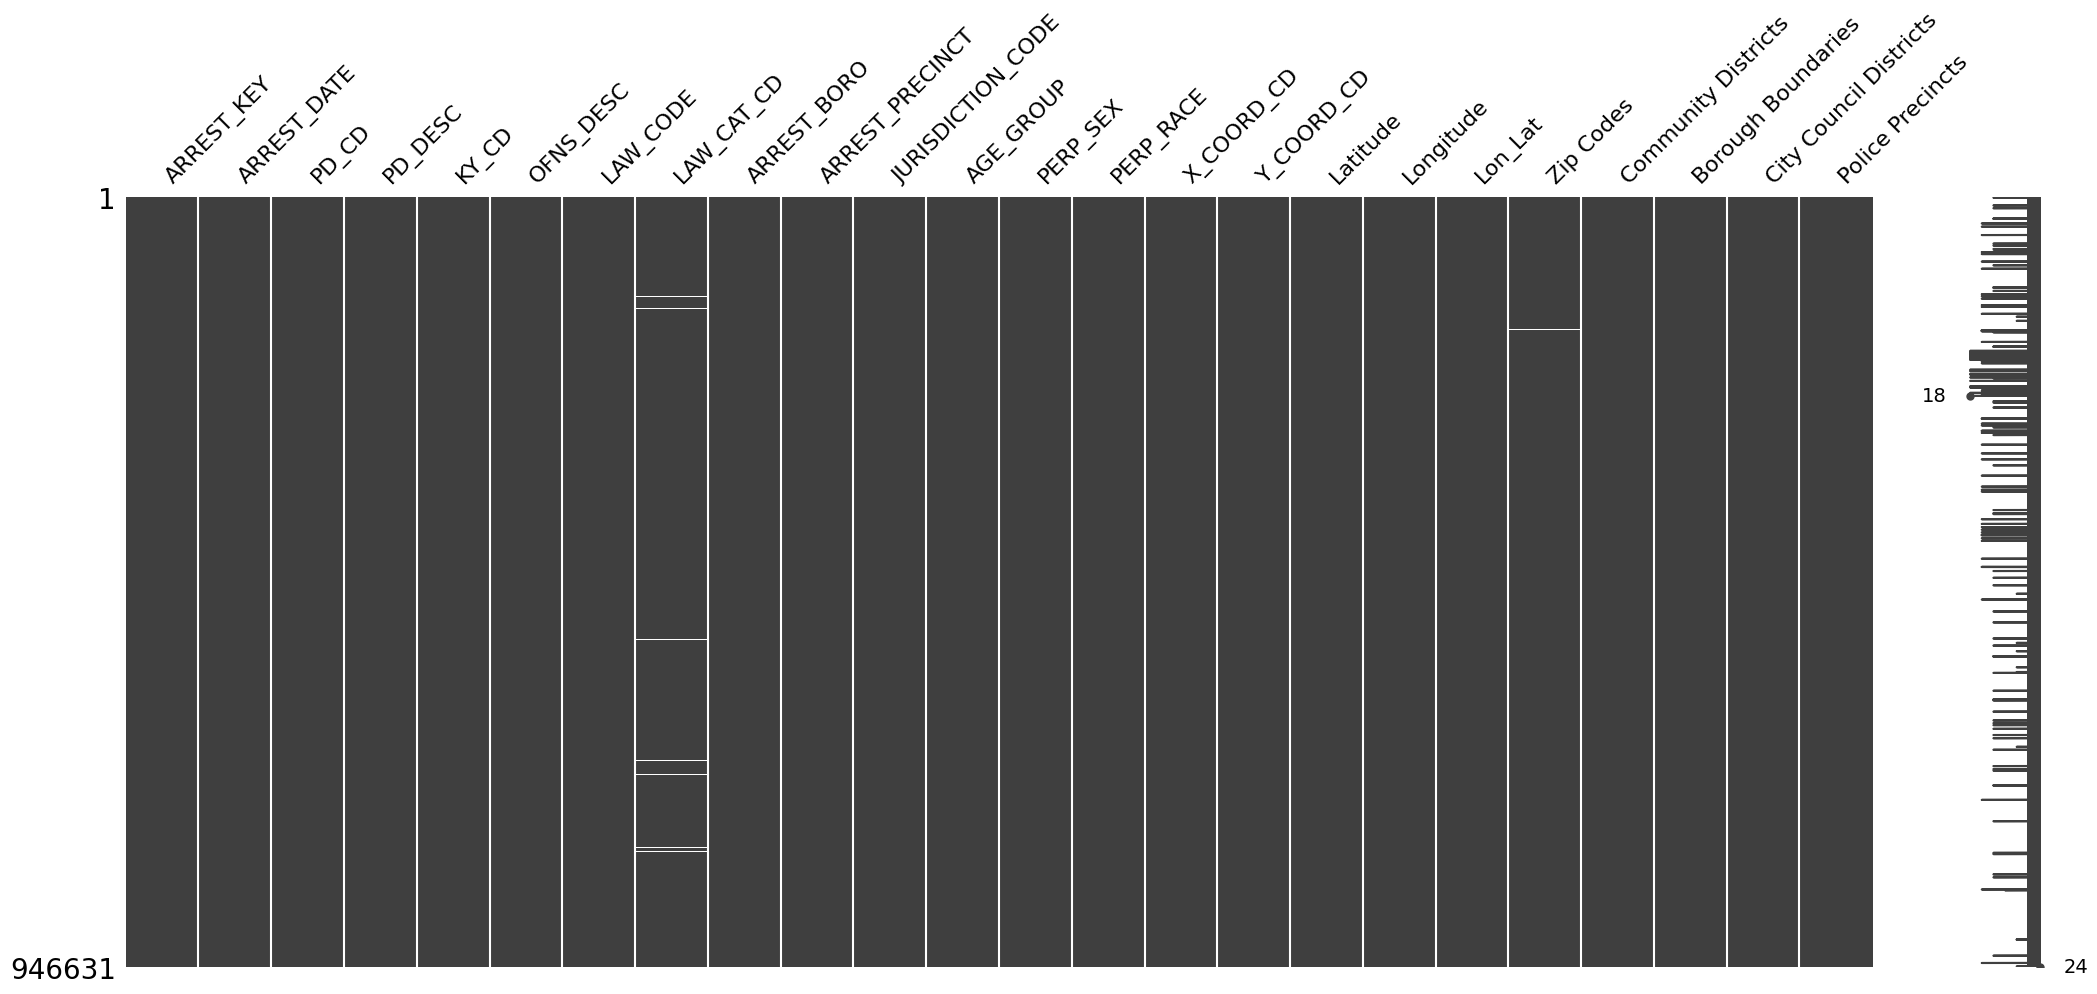

In [ ]:
msno.matrix(df_2018_2022)

<Axes: >

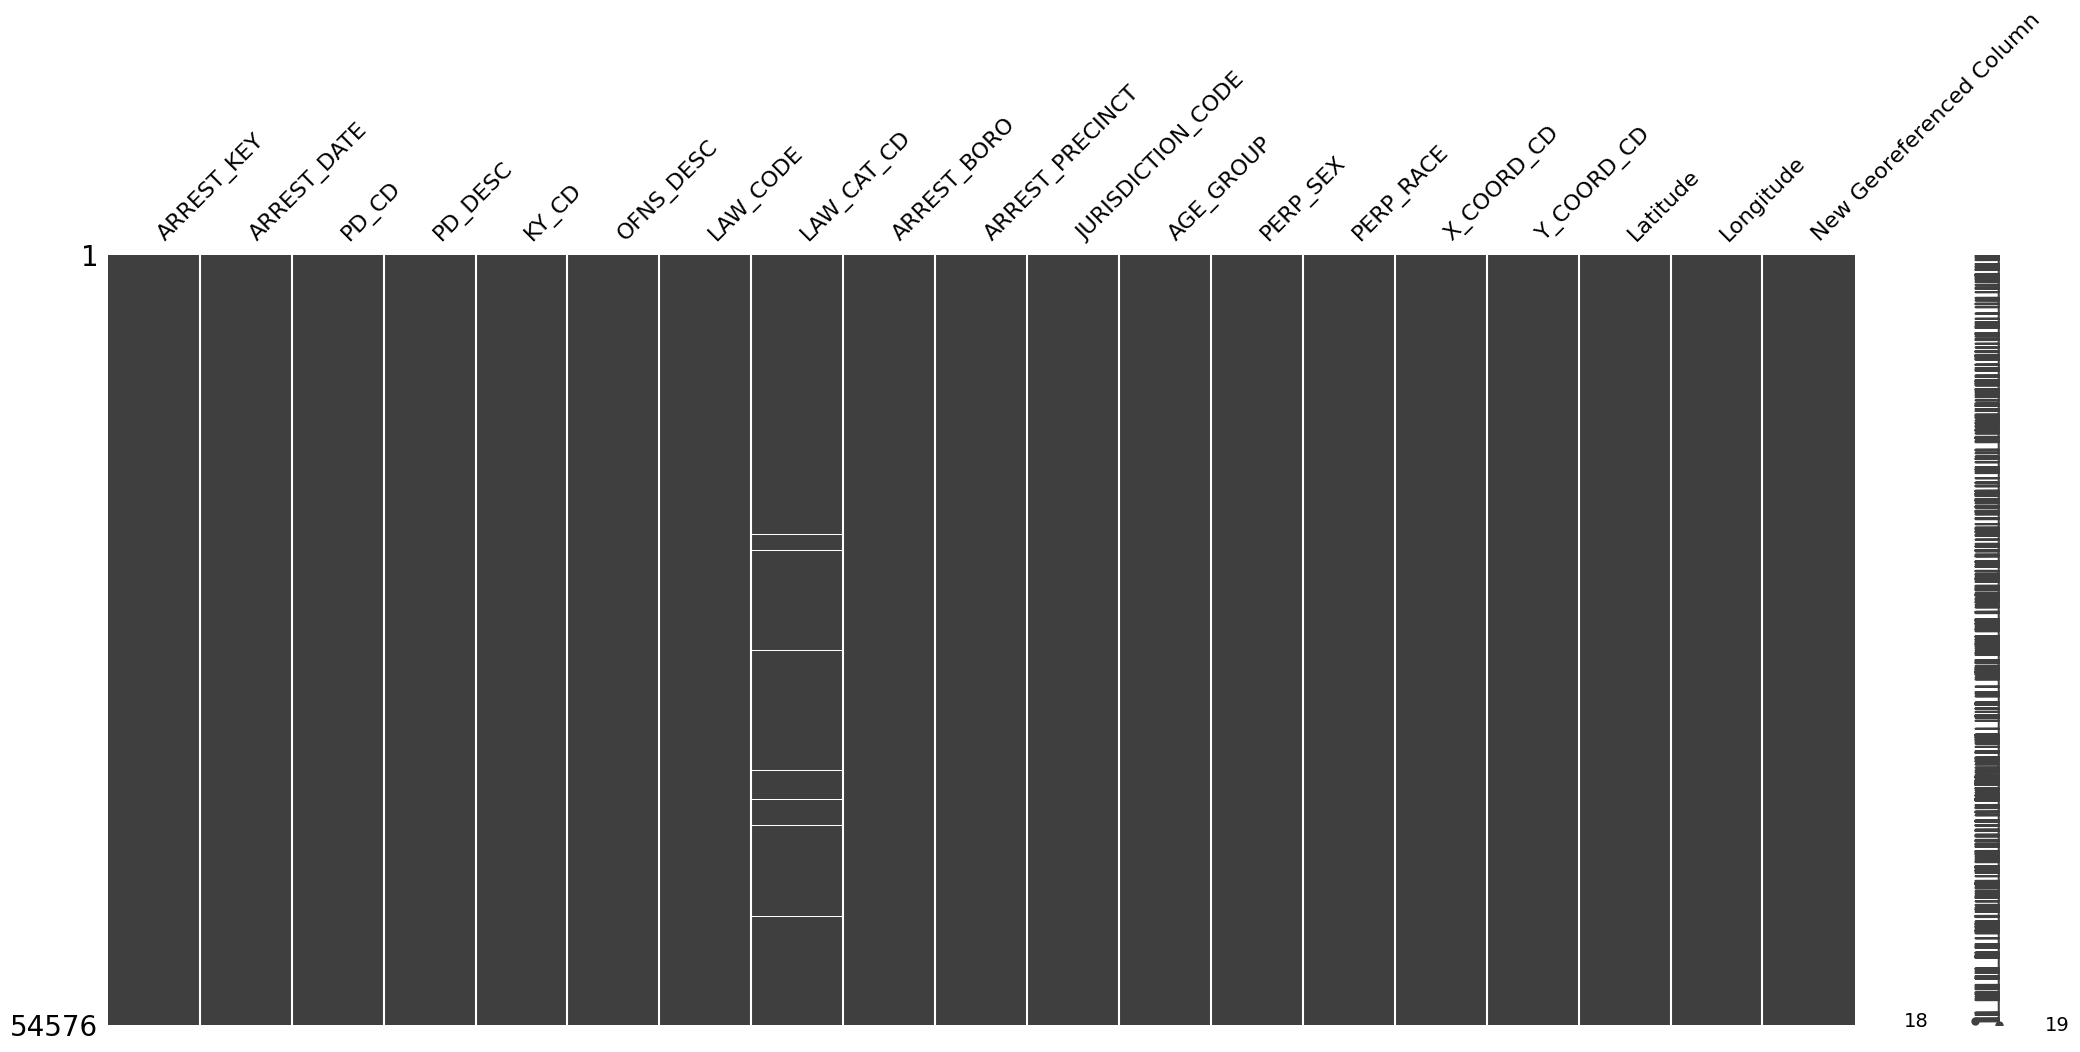

In [ ]:
msno.matrix(df_2023)

## Heatmap:

<Axes: >

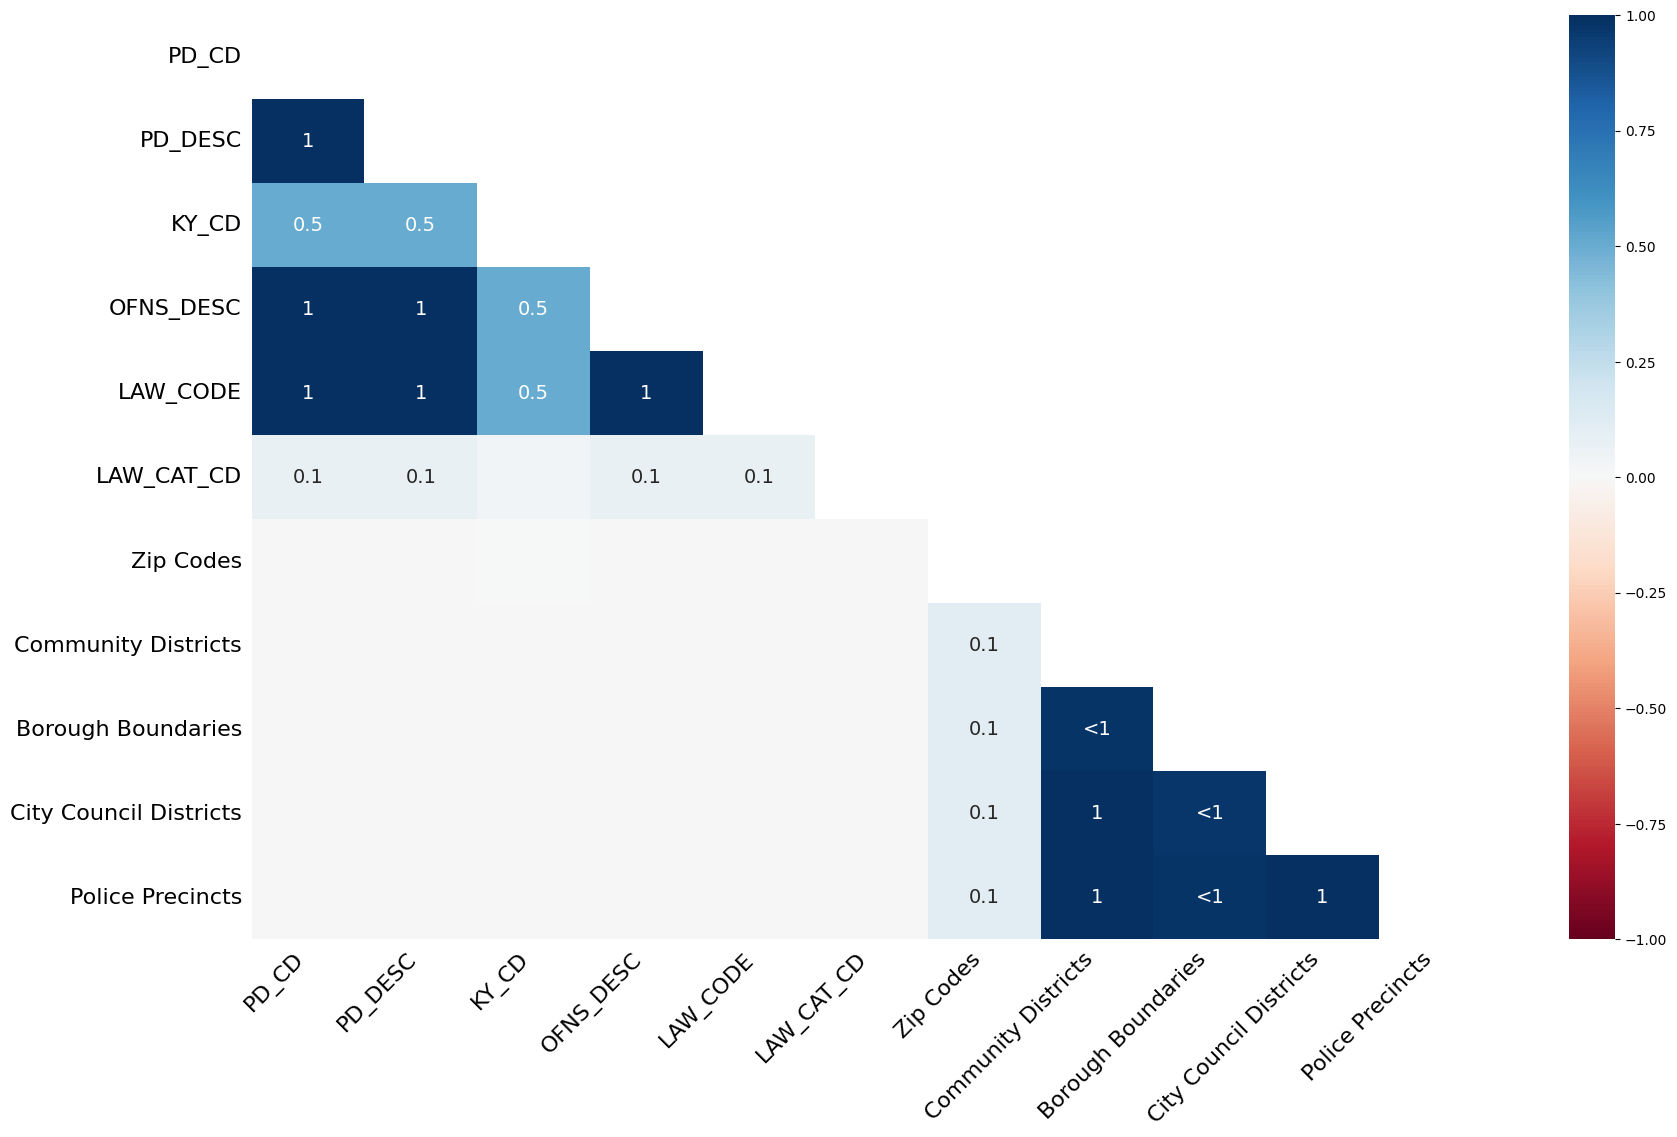

In [ ]:
msno.heatmap(df_2018_2022)

<Axes: >

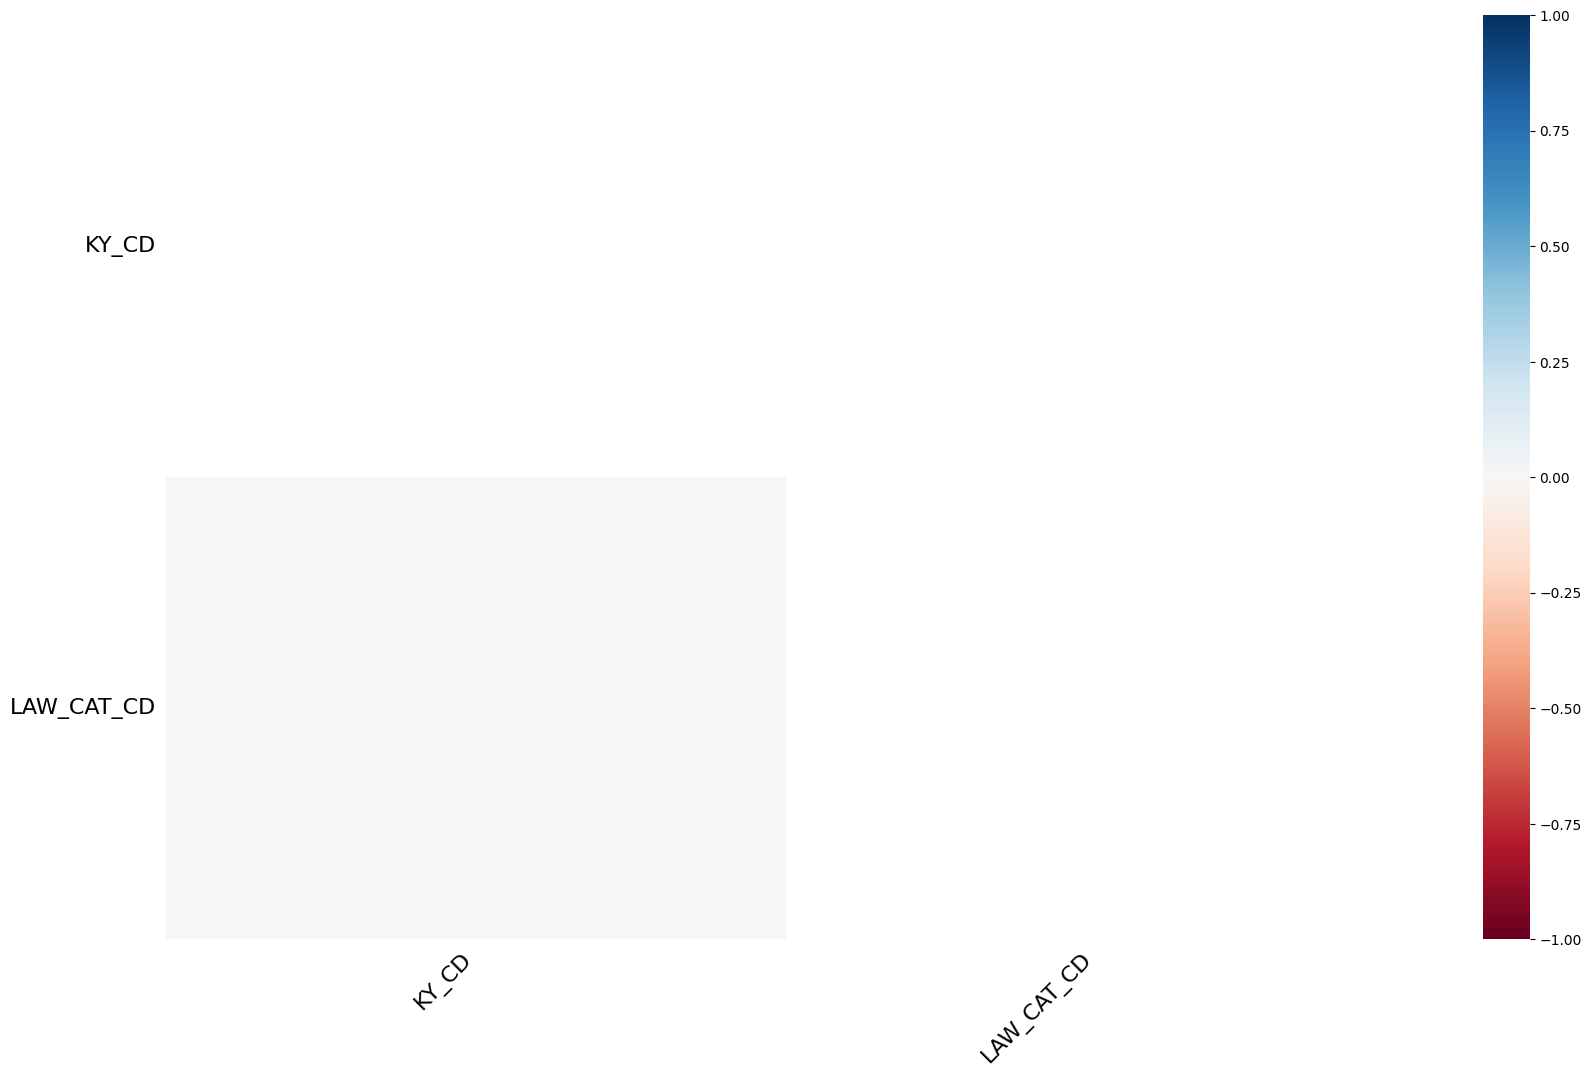

In [ ]:
msno.heatmap(df_2023)

#Limpiar datos:

In [ ]:
#Eliminar valores restantes de nan:
df_2018_2022 = df_2018_2022.dropna()
df_2023 = df_2023.dropna()

# Tamaño final de los archivos:

In [ ]:
print("Tamaño 2018-2022: ", df_2018_2022.shape)
print("Tamaño 2023:      ", df_2023.shape)

Tamaño 2018-2022:  (936759, 24)
Tamaño 2023:       (54123, 19)


# Información cuantitativa de los datos:

In [ ]:
df_2018_2022.describe()

ARREST_KEY      KY_CD  ARREST_PRECINCT  JURISDICTION_CODE  \
count    936759.000 936759.000       936759.000         936759.000   
mean  211984162.666    248.864           62.803              1.593   
std    24496924.472    136.354           34.919             11.050   
min   173151561.000    101.000            1.000              0.000   
25%   191076576.000    115.000           40.000              0.000   
50%   208423352.000    236.000           62.000              0.000   
75%   233658648.500    344.000          100.000              0.000   
max   261197497.000    882.000          123.000             97.000   

       X_COORD_CD  Y_COORD_CD   Latitude  Longitude  Zip Codes  \
count  936759.000  936759.000 936759.000 936759.000 936759.000   
mean  1005325.227  208195.095     40.738    -73.924  14457.446   
std     21371.459   29962.865      0.082      0.077   3833.058   
min    913512.000  121131.000     40.499    -74.254  10090.000   
25%    991374.000  185676.000     40.676    -73.974  11606.000   
50%   1004950.000  206781.000     40.734    -73.925  13094.000   
75%   1017314.000  236090.000     40.815    -73.881  17213.000   
max   1067185.000  271909.000     40.913    -73.701  26001.000   

       Community Districts  Borough Boundaries  City Council Districts  \
count           936759.000          936759.000              936759.000   
mean                36.616               3.339                  27.836   
std                 21.089               1.218                  14.491   
min                  1.000               1.000                   1.000   
25%                 17.000               2.000                  14.000   
50%                 39.000               3.000                  30.000   
75%                 55.000               4.000                  40.000   
max                 71.000               5.000                  51.000   

       Police Precincts  
count        936759.000  
mean             38.751  
std              21.678  
min               1.000  
25%              23.000  
50%              37.000  
75%              58.000  
max              77.000

In [ ]:
df_2023.describe()

ARREST_KEY     KY_CD  ARREST_PRECINCT  JURISDICTION_CODE  X_COORD_CD  \
count     54123.000 54123.000        54123.000          54123.000   54123.000   
mean  263581557.624   245.791           63.795              0.970 1005890.331   
std     1401799.358   134.692           34.441              7.872   21772.817   
min   261180920.000   101.000            1.000              0.000       0.000   
25%   262334570.500   113.000           40.000              0.000  991742.500   
50%   263589203.000   236.000           63.000              0.000 1005778.000   
75%   264755651.500   344.000          101.000              0.000 1017737.500   
max   266004089.000   881.000          123.000             97.000 1066940.000   

       Y_COORD_CD  Latitude  Longitude  
count   54123.000 54123.000  54123.000  
mean   208264.776    40.738    -73.920  
std     29816.315     0.193      0.327  
min         0.000     0.000    -74.252  
25%    185868.500    40.677    -73.973  
50%    206619.000    40.734    -73.922  
75%    236537.000    40.816    -73.879  
max    271819.000    40.913      0.000

# Información cualitativa de los datos (Datos no numéricos):

In [ ]:
df_2018_2022.describe(include = "O")

ARREST_DATE      PD_CD    PD_DESC                     OFNS_DESC  \
count       936759 936759.000     936759                        936759   
unique        1825    306.000        389                            83   
top     01/11/2018    101.000  ASSAULT 3  ASSAULT 3 & RELATED OFFENSES   
freq          1068 110392.000     110392                        147201   

          LAW_CODE LAW_CAT_CD ARREST_BORO AGE_GROUP PERP_SEX PERP_RACE  \
count       936759     936759      936759    936759   936759    936759   
unique        1677          5           5         5        2         7   
top     PL 1200001          M           K     25-44        M     BLACK   
freq         94191     536757      255863    512615   770476    456279   

                                             Lon_Lat  
count                                         936759  
unique                                        118515  
top     POINT (-73.88151172399995 40.67141166300007)  
freq                                            5398

In [ ]:
df_2023.describe(include = "O")

ARREST_DATE     PD_CD                         PD_DESC  \
count        54123 54123.000                           54123   
unique          90   211.000                             203   
top     02/01/2023   339.000  LARCENY,PETIT FROM OPEN AREAS,   
freq           881  5837.000                            5837   

                           OFNS_DESC    LAW_CODE LAW_CAT_CD ARREST_BORO  \
count                          54123       54123      54123       54123   
unique                            60         736          5           5   
top     ASSAULT 3 & RELATED OFFENSES  PL 1552500          M           K   
freq                            7888        5837      30292       15157   

       AGE_GROUP PERP_SEX PERP_RACE      New Georeferenced Column  
count      54123    54123     54123                         54123  
unique         5        3         7                         16421  
top        25-44        M     BLACK  POINT (-73.881509 40.671404)  
freq       31186    44666     26529                           366

# [Pregunta 1 y 3] Cantidad de crímenes anuales:

In [ ]:
# Crear DataFrame para graficar:
data_hist_1822 = pd.DataFrame([pd.to_datetime(df_2018_2022["ARREST_DATE"]).dt.year, df_2018_2022["PERP_SEX"], df_2018_2022["PERP_RACE"], df_2018_2022["AGE_GROUP"]]).T
data_hist_23 = pd.DataFrame([pd.to_datetime(df_2023["ARREST_DATE"]).dt.year, df_2023["PERP_SEX"], df_2023["PERP_RACE"], df_2023["AGE_GROUP"]]).T
data_hist = pd.concat([data_hist_1822, data_hist_23])

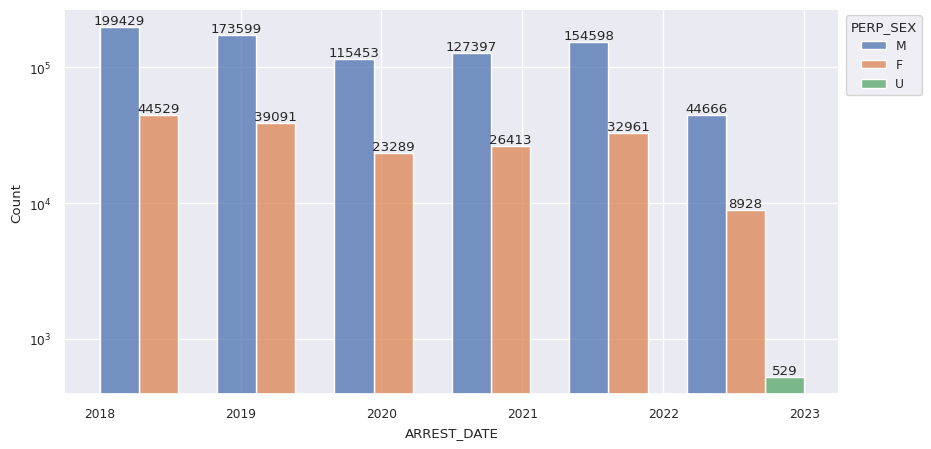

In [ ]:
# Histograma crimenes anuales [Por sexo]:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.histplot(data = data_hist, x = "ARREST_DATE", hue="PERP_SEX", bins = 6, multiple="dodge")
plt.yscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
for container in g.containers:
    g.bar_label(container)

plt.show()

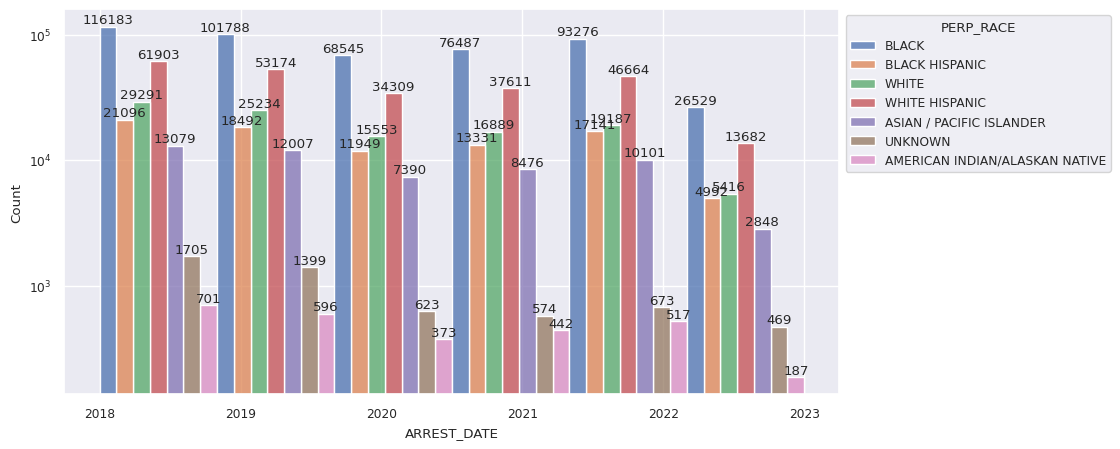

In [ ]:
# Histograma crimenes anuales [Por raza]:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.histplot(data = data_hist, x = "ARREST_DATE", hue="PERP_RACE", bins = 6, multiple="dodge")
plt.yscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
for container in g.containers:
    g.bar_label(container)

plt.show()

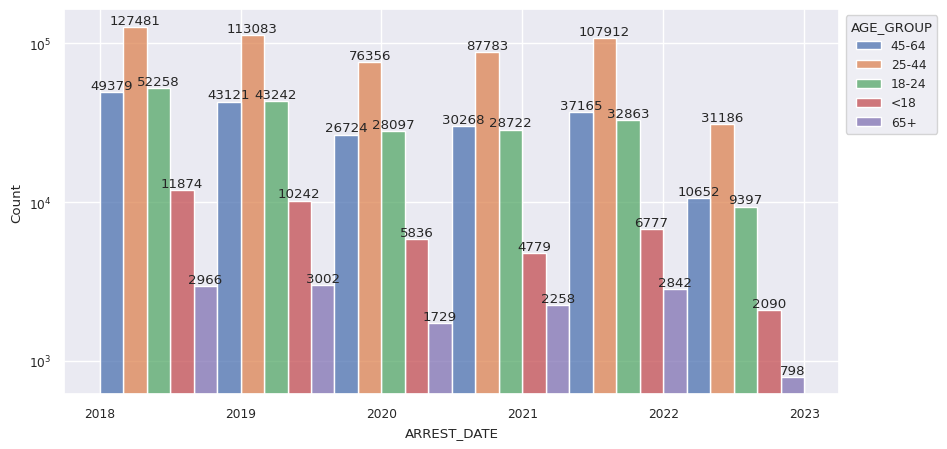

In [ ]:
# Histograma crimenes anuales [Por edad]:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.histplot(data = data_hist, x = "ARREST_DATE", hue="AGE_GROUP", bins = 6, multiple="dodge")
plt.yscale('log')
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 2] Cantidad de crímenes por dias y meses:

In [ ]:
# Crear DataFrame para graficar:
data_hist_1822 = pd.DataFrame([pd.to_datetime(df_2018_2022["ARREST_DATE"])]).T
data_hist_23 = pd.DataFrame([pd.to_datetime(df_2023["ARREST_DATE"])]).T
data_hist = pd.concat([data_hist_1822, data_hist_23])

data_hist["Dia"] = data_hist['ARREST_DATE'].dt.day_name()
data_hist["Mes"] = data_hist['ARREST_DATE'].dt.month_name()

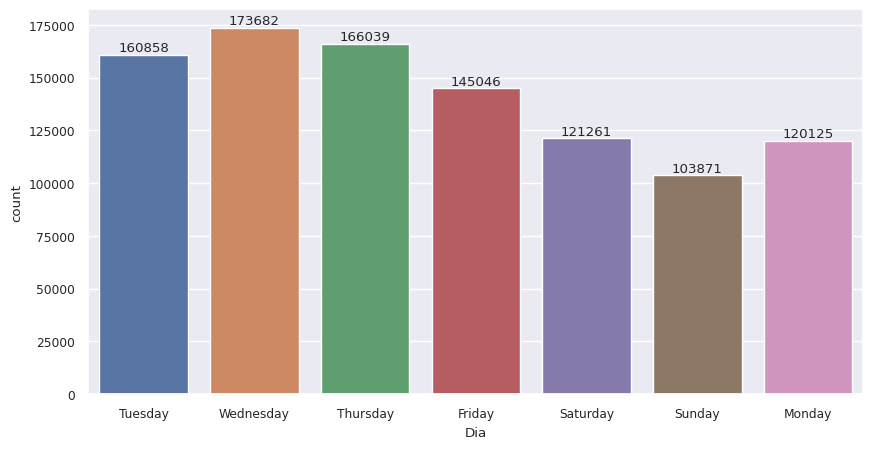

In [ ]:
# Tamaño de fuente:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)

# Histograma crimenes por día:
g = sns.countplot(data = data_hist, x = "Dia")

for container in g.containers:
    g.bar_label(container)

plt.show()

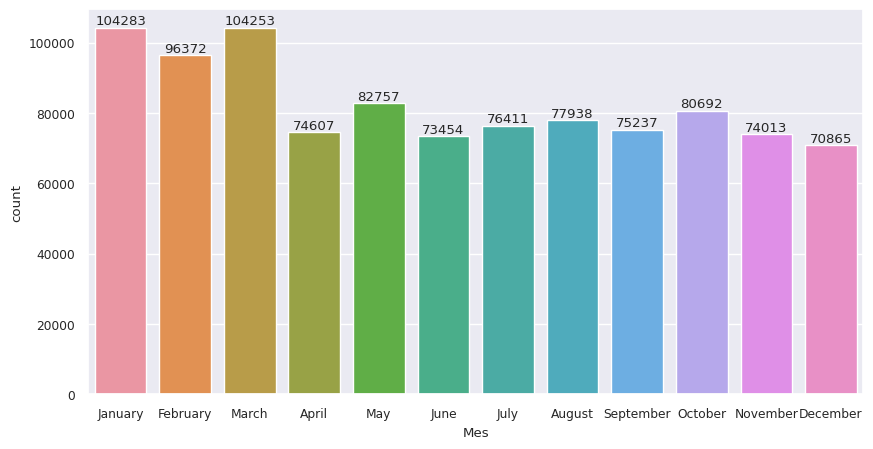

In [ ]:
# Histograma crimenes por mes:
g = sns.countplot(data = data_hist, x = "Mes")

for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 4] Tipos de crímenes más comúnes:

In [ ]:
# Crear DataFrame para graficar:
data_hist = pd.concat([df_2018_2022, df_2023])
data_hist = pd.DataFrame(data_hist["OFNS_DESC"])

# Mostrar cantidad de crímenes:
n_crim = data_hist.apply(lambda x: x.value_counts().fillna(0))
n_crim.head(n=40)

OFNS_DESC
ASSAULT 3 & RELATED OFFENSES                    155089
PETIT LARCENY                                    96014
DANGEROUS DRUGS                                  89329
FELONY ASSAULT                                   83196
MISCELLANEOUS PENAL LAW                          59792
VEHICLE AND TRAFFIC LAWS                         53743
ROBBERY                                          46557
GRAND LARCENY                                    45054
DANGEROUS WEAPONS                                41585
CRIMINAL MISCHIEF & RELATED OF                   40271
BURGLARY                                         27891
OFFENSES AGAINST PUBLIC ADMINI                   24364
FORGERY                                          19595
SEX CRIMES                                       19325
INTOXICATED & IMPAIRED DRIVING                   17719
OFF. AGNST PUB ORD SENSBLTY &                    17415
OFFENSES INVOLVING FRAUD                         13935
CRIMINAL TRESPASS                                12365
OTHER TRAFFIC INFRACTION                         11742
POSSESSION OF STOLEN PROPERTY                    10764
OTHER OFFENSES RELATED TO THEF                   10214
CRIMINAL MISCHIEF & RELATED OFFENSES             10179
OFFENSES AGAINST PUBLIC ADMINISTRATION            7702
OTHER OFFENSES RELATED TO THEFT                   7331
GRAND LARCENY OF MOTOR VEHICLE                    6313
MURDER & NON-NEGL. MANSLAUGHTE                    5845
OFFENSES AGAINST THE PERSON                       5012
OTHER STATE LAWS                                  3917
PROSTITUTION & RELATED OFFENSES                   3898
RAPE                                              3792
NYS LAWS-UNCLASSIFIED FELONY                      3701
FRAUDS                                            3247
BURGLAR'S TOOLS                                   3219
OTHER STATE LAWS (NON PENAL LA                    3122
OFF. AGNST PUB ORD SENSBLTY & RGHTS TO PRIV       2862
INTOXICATED/IMPAIRED DRIVING                      2521
UNAUTHORIZED USE OF A VEHICLE                     2314
ADMINISTRATIVE CODE                               2090
GAMBLING                                          2086
ALCOHOLIC BEVERAGE CONTROL LAW                    1694

# [Pregunta 5] Tipos de crímenes más comúnes según el día de la semana:

In [ ]:
# Crear DataFrame para graficar:
data_hist_1822 = pd.DataFrame([pd.to_datetime(df_2018_2022["ARREST_DATE"]).dt.day_name(), df_2018_2022["PD_DESC"]]).T
data_hist_23 = pd.DataFrame([pd.to_datetime(df_2023["ARREST_DATE"]).dt.day_name(), df_2023["PD_DESC"]]).T
data_hist = pd.concat([data_hist_1822, data_hist_23])

In [ ]:
# Mostrar cantidad de crímenes:
sns.set(rc = {'figure.figsize':(10, 500)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "PD_DESC", hue = "ARREST_DATE")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

Output hidden; open in https://colab.research.google.com to view.

# [Pregunta 6] Distribución por nivel de delito:

In [ ]:
# Crear DataFrame para graficar:
data_hist = pd.concat([df_2018_2022, df_2023])
data_hist = pd.DataFrame(data_hist[["LAW_CAT_CD", "ARREST_BORO", "ARREST_PRECINCT", "JURISDICTION_CODE"]])

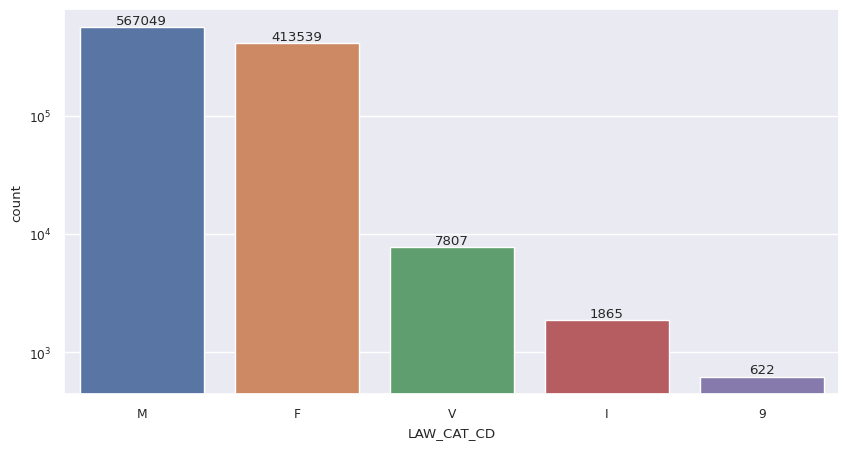

In [ ]:
# Mostrar cantidad de crímenes:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "LAW_CAT_CD")
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

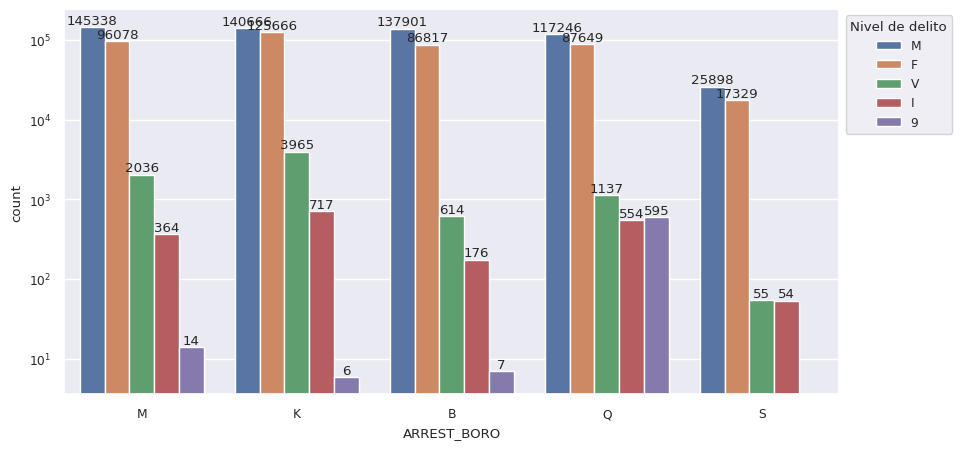

In [ ]:
# Mostrar cantidad de crímenes (Distrito):
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "ARREST_BORO", hue = "LAW_CAT_CD")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Nivel de delito')
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

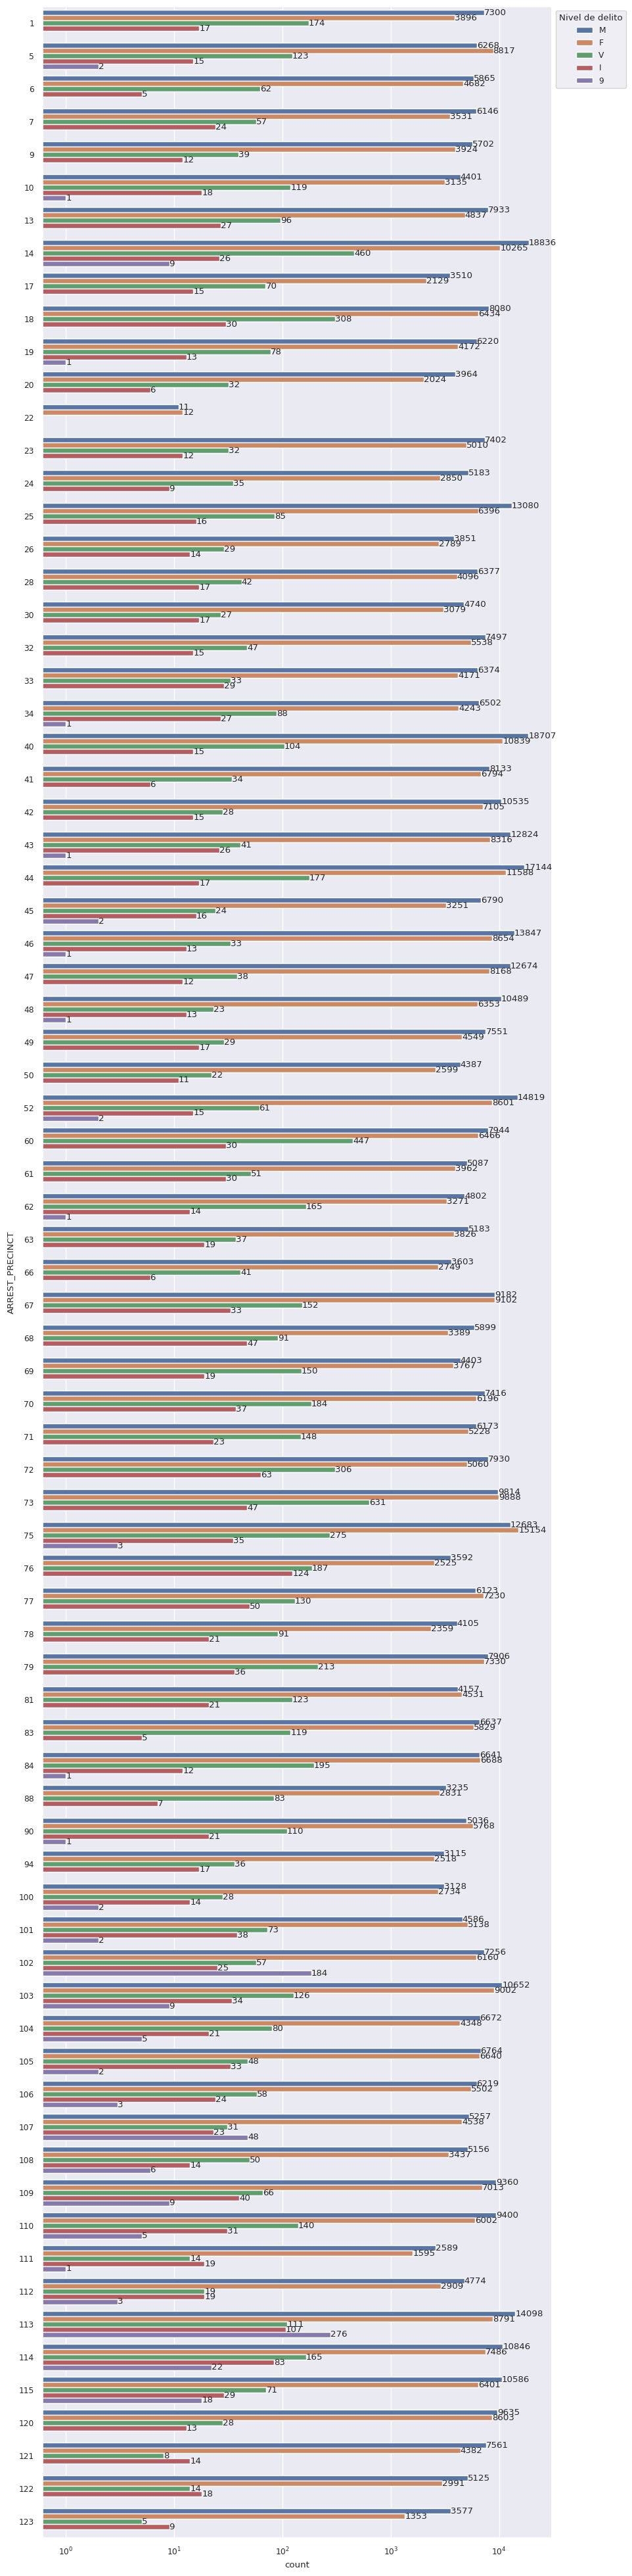

In [ ]:
# Mostrar cantidad de crímenes (Comisaría):
sns.set(rc = {'figure.figsize':(10, 50)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "ARREST_PRECINCT", hue = "LAW_CAT_CD")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Nivel de delito')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

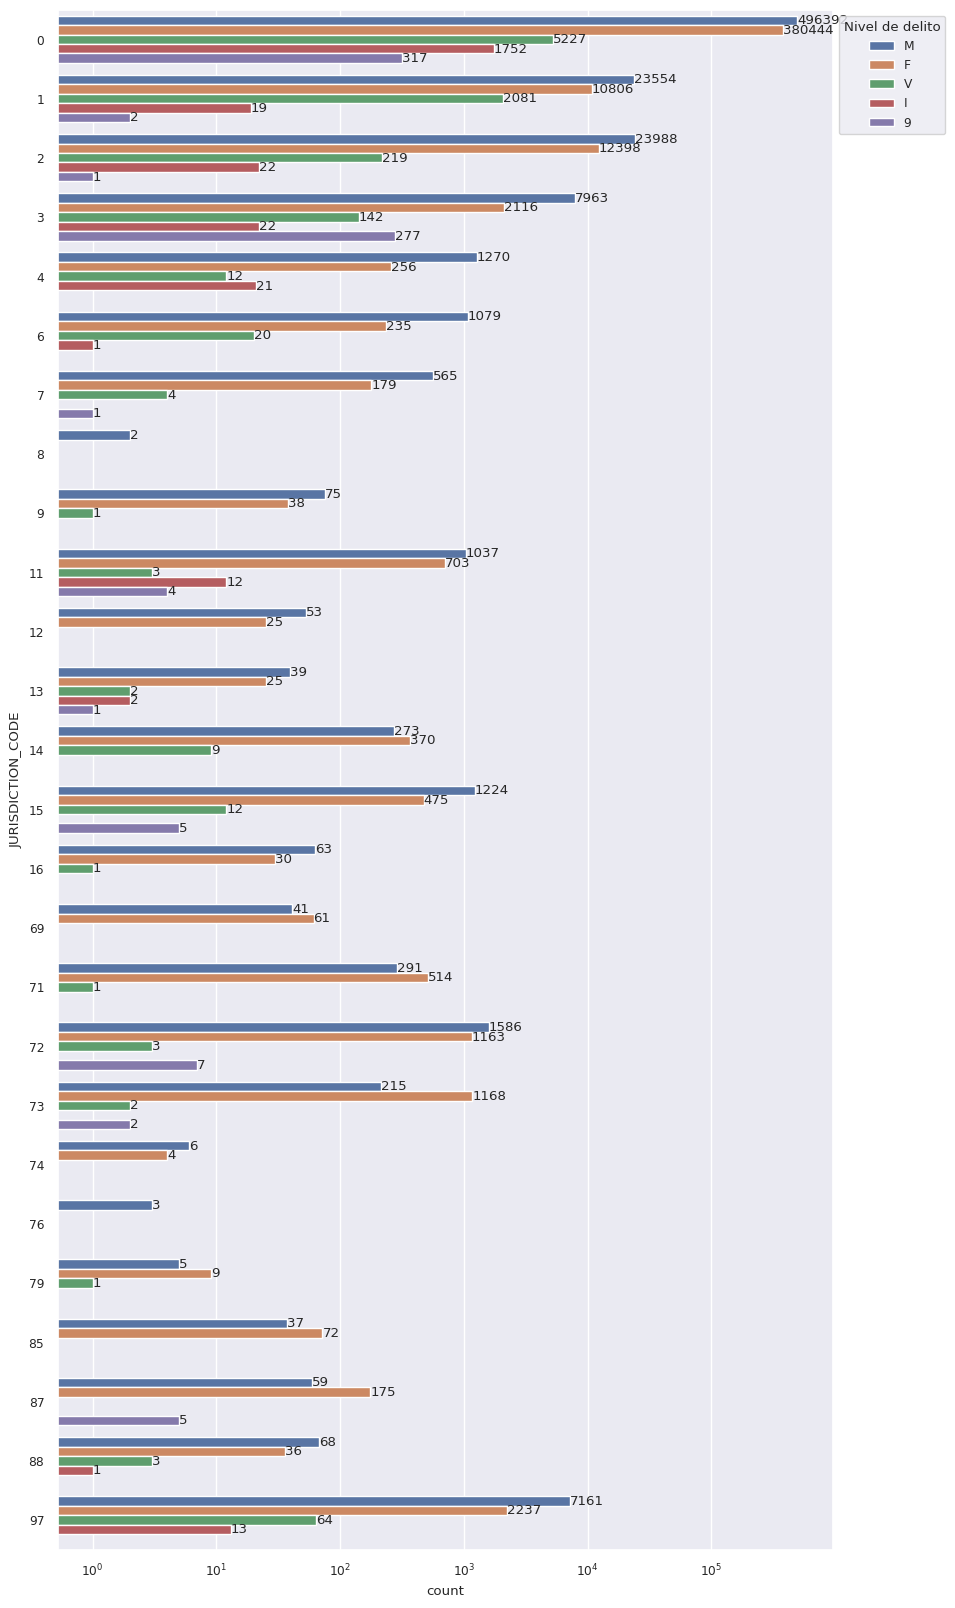

In [ ]:
# Mostrar cantidad de crímenes (Jurisdicción):
sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "JURISDICTION_CODE", hue = "LAW_CAT_CD")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Nivel de delito')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 7] Niveles de delito más comúnes según el día de la semana:

In [ ]:
# Crear DataFrame para graficar:
data_hist_1822 = pd.DataFrame([pd.to_datetime(df_2018_2022["ARREST_DATE"]).dt.day_name(), df_2018_2022["LAW_CAT_CD"]]).T
data_hist_23 = pd.DataFrame([pd.to_datetime(df_2023["ARREST_DATE"]).dt.day_name(), df_2023["LAW_CAT_CD"]]).T
data_hist = pd.concat([data_hist_1822, data_hist_23])

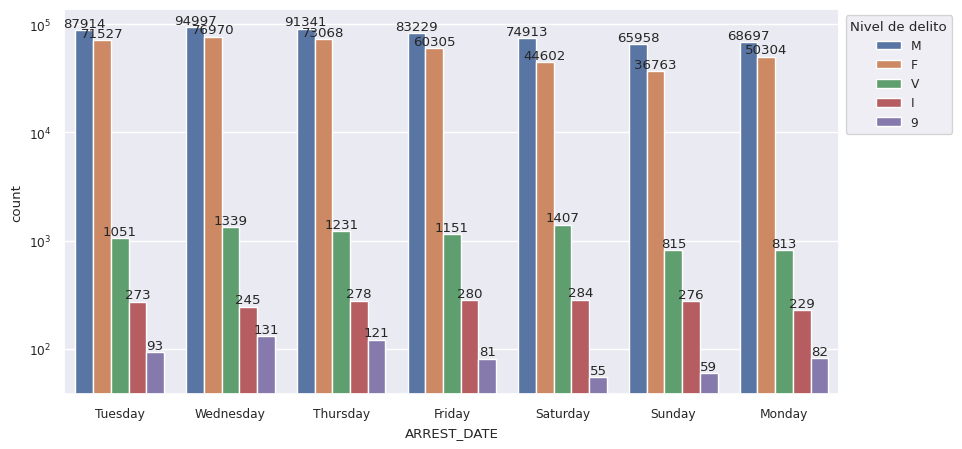

In [ ]:
# Mostrar cantidad de crímenes:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "ARREST_DATE", hue = "LAW_CAT_CD")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Nivel de delito')
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 8] Distribución de crímenes por edad:

In [ ]:
# Crear DataFrame para graficar:
data_hist = pd.concat([df_2018_2022, df_2023])
data_hist = pd.DataFrame(data_hist[["AGE_GROUP", "ARREST_BORO", "ARREST_PRECINCT", "JURISDICTION_CODE"]])

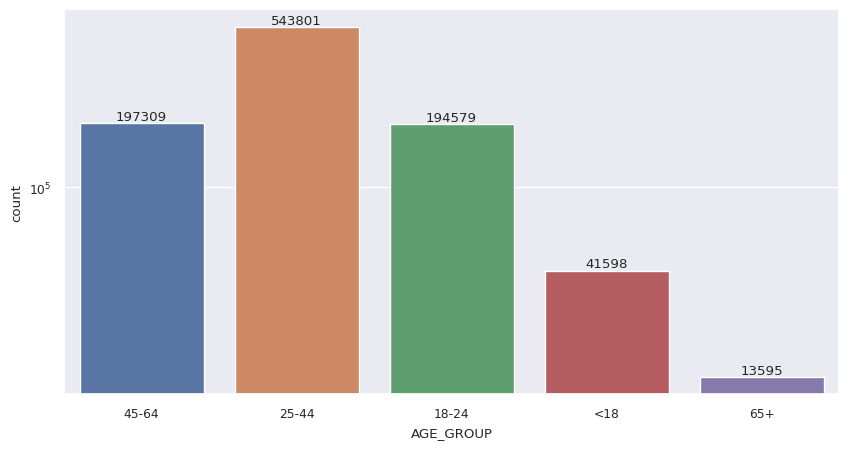

In [ ]:
# Mostrar cantidad de crímenes:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "AGE_GROUP")
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

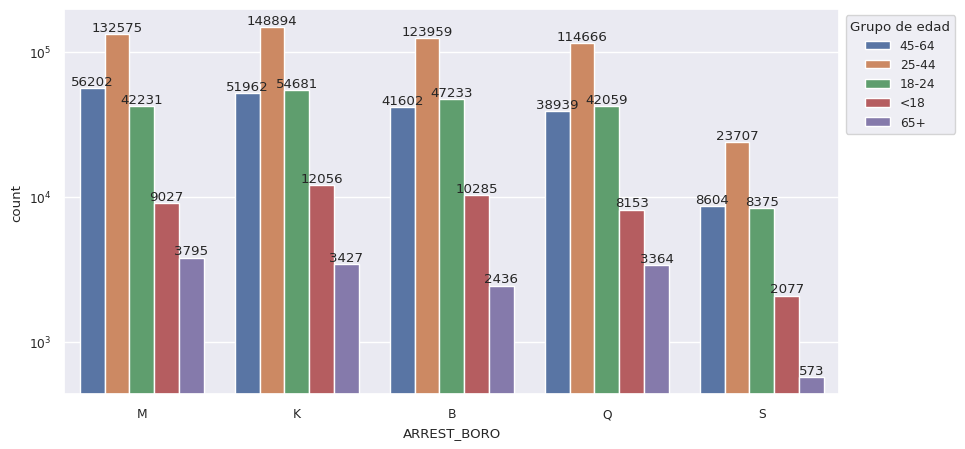

In [ ]:
# Mostrar cantidad de crímenes (Distrito):
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "ARREST_BORO", hue = "AGE_GROUP")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Grupo de edad')
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

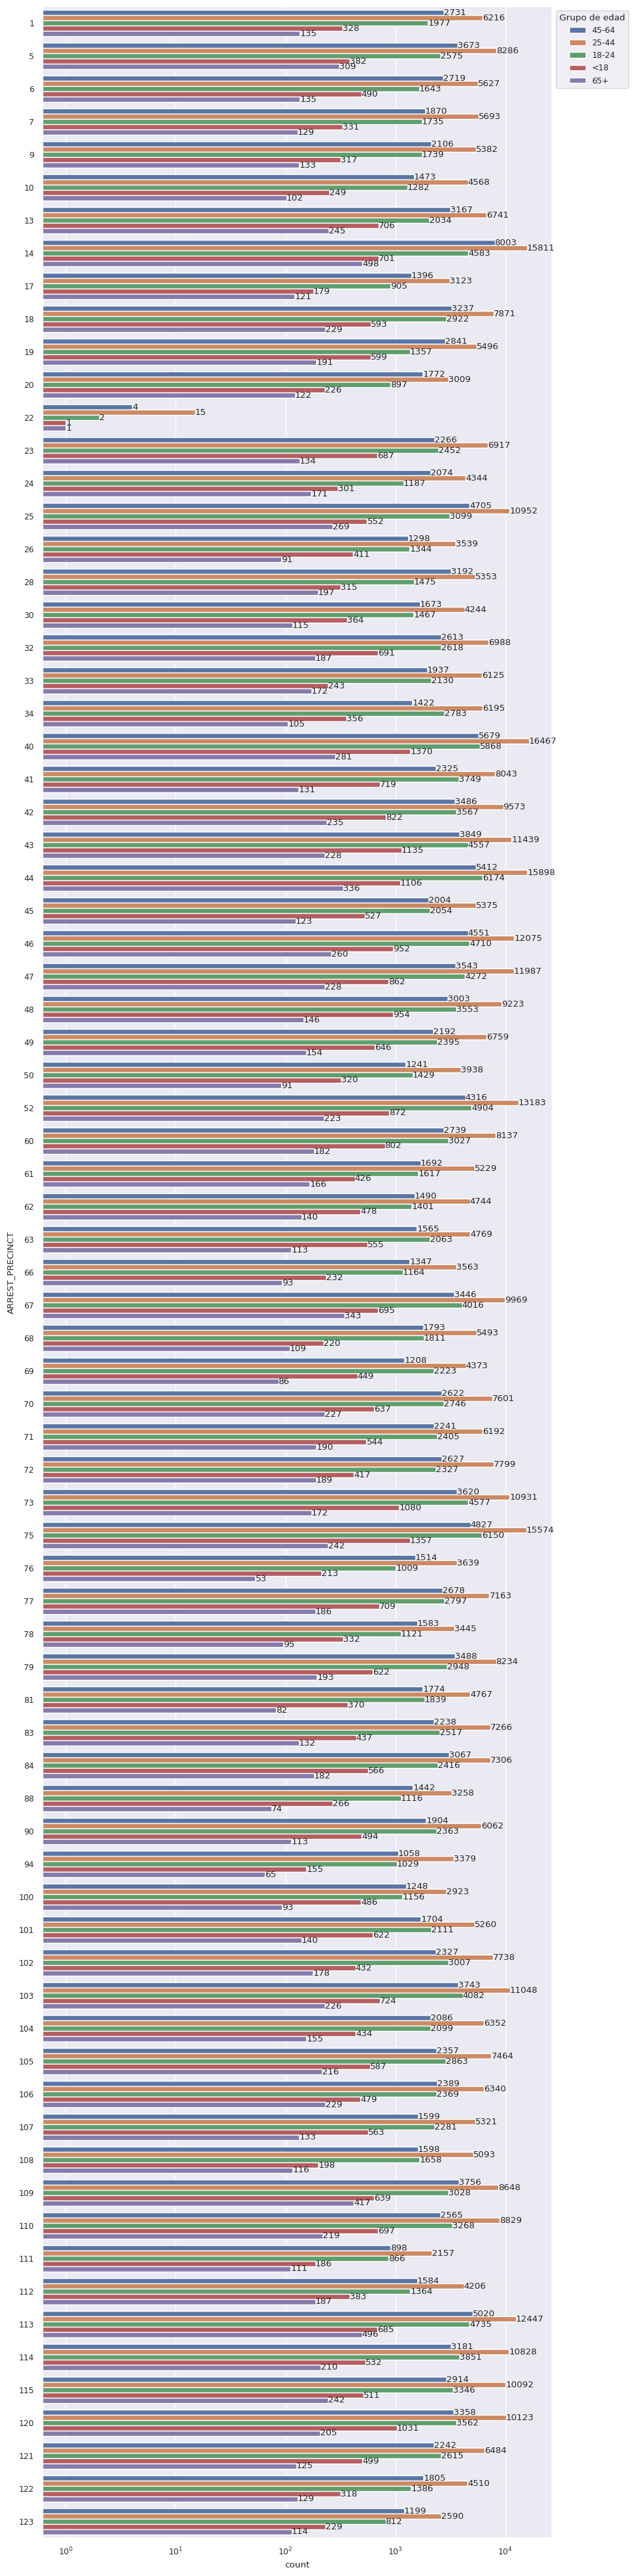

In [ ]:
# Mostrar cantidad de crímenes (Comisaría):
sns.set(rc = {'figure.figsize':(10, 50)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "ARREST_PRECINCT", hue = "AGE_GROUP")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Grupo de edad')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

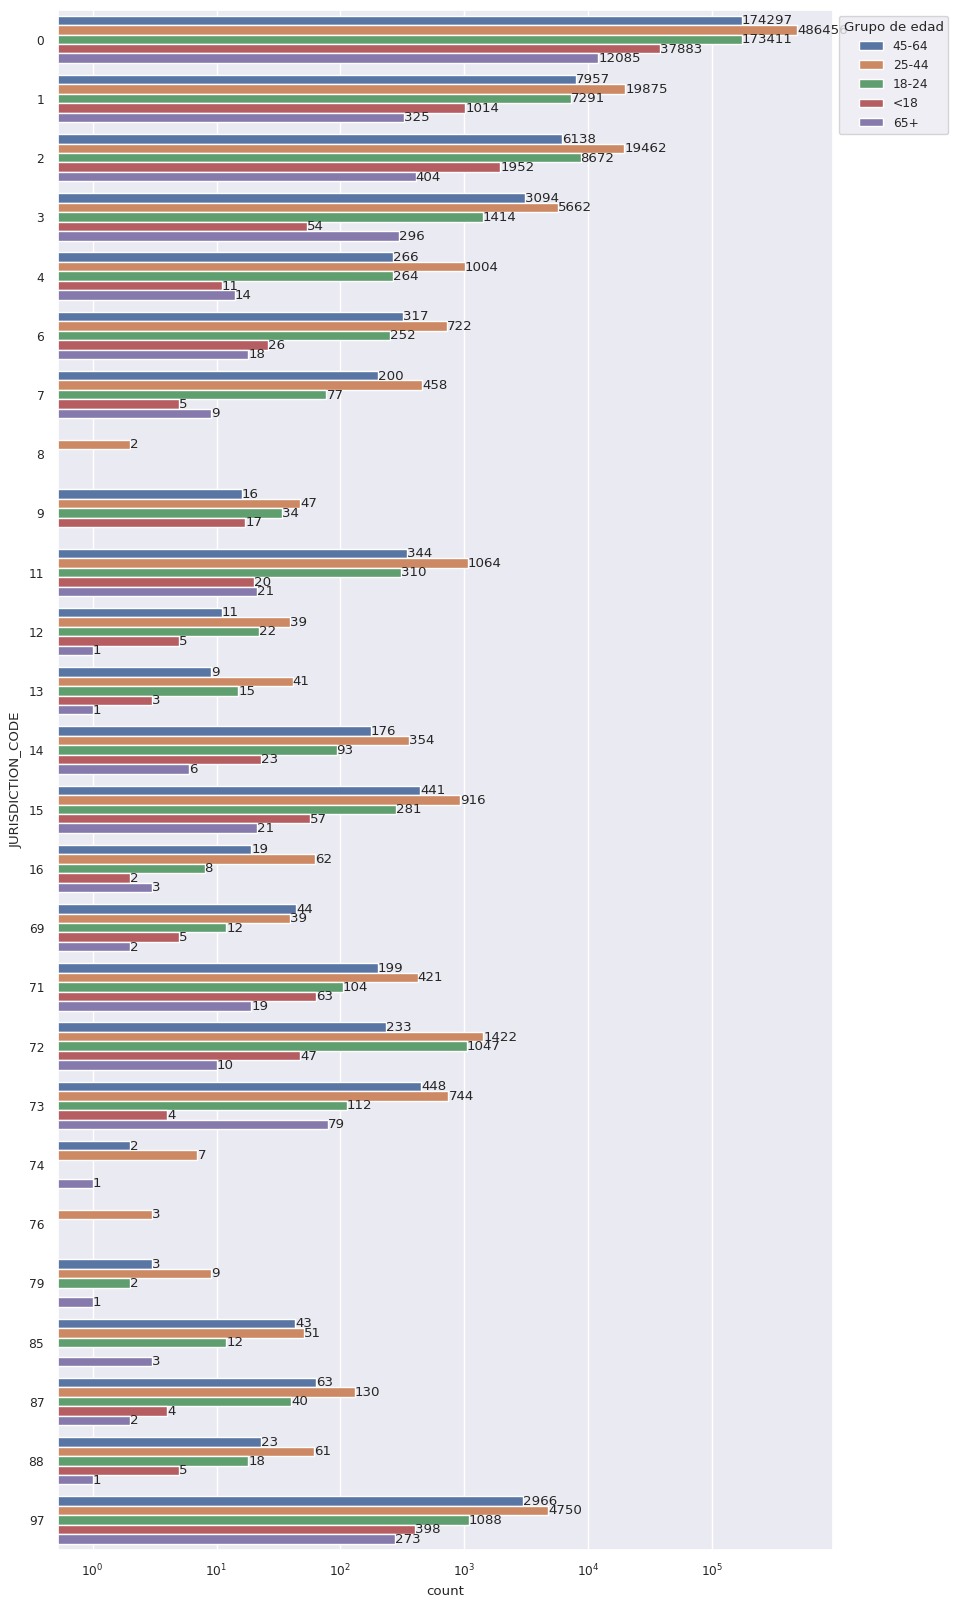

In [ ]:
# Mostrar cantidad de crímenes (Jurisdicción):
sns.set(rc = {'figure.figsize':(10, 20)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "JURISDICTION_CODE", hue = "AGE_GROUP")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Grupo de edad')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 9] Distribución de crímenes por sexo:

In [ ]:
# Crear DataFrame para graficar:
data_hist = pd.concat([df_2018_2022, df_2023])
data_hist = pd.DataFrame(data_hist[["PERP_SEX", "ARREST_BORO", "ARREST_PRECINCT", "JURISDICTION_CODE"]])

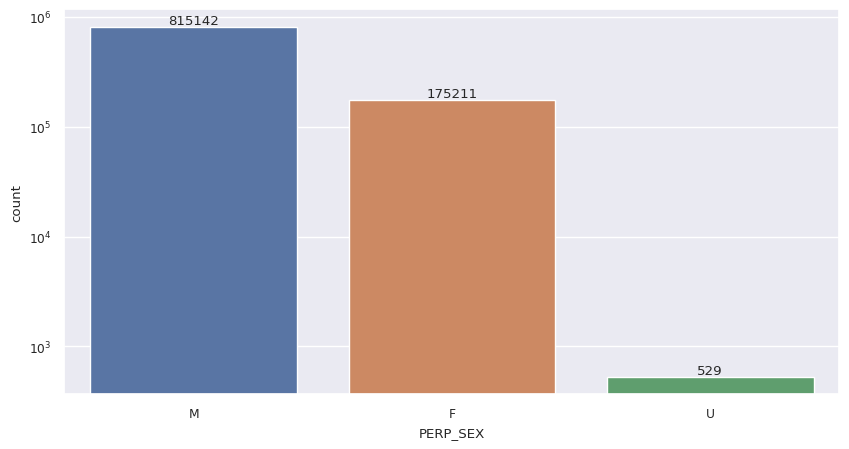

In [ ]:
# Mostrar cantidad de crímenes (Distrito):
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "PERP_SEX")
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

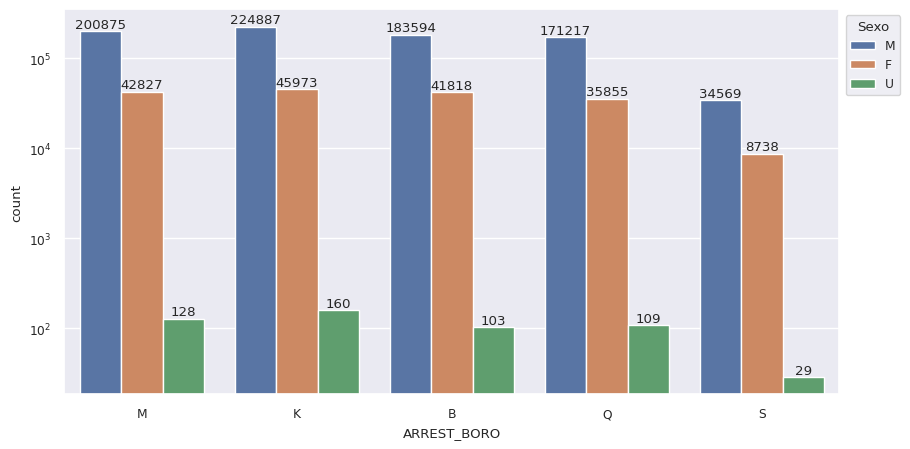

In [ ]:
# Mostrar cantidad de crímenes (Distrito):
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "ARREST_BORO", hue = "PERP_SEX")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Sexo')
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

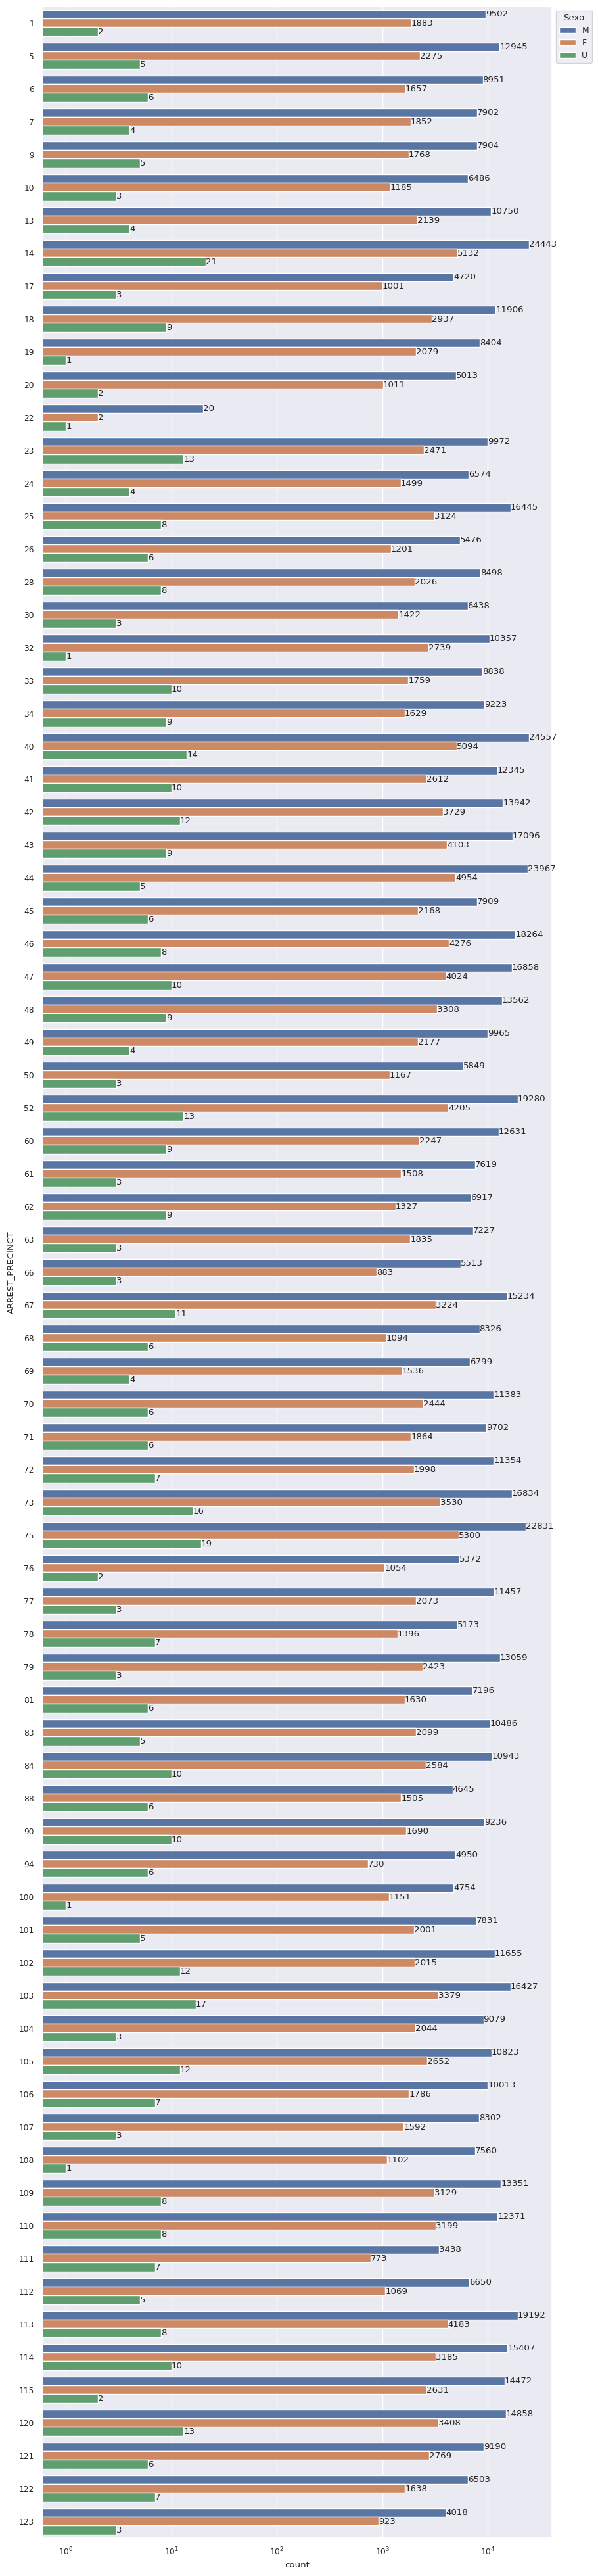

In [ ]:
# Mostrar cantidad de crímenes (Comisaría):
sns.set(rc = {'figure.figsize':(10, 50)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "ARREST_PRECINCT", hue = "PERP_SEX")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Sexo')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

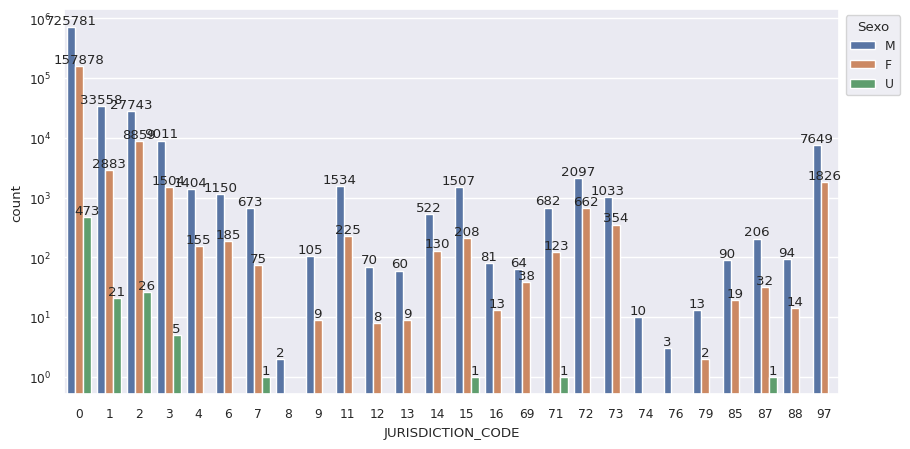

In [ ]:
# Mostrar cantidad de crímenes (Jurisdicción):
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "JURISDICTION_CODE", hue = "PERP_SEX")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Sexo')
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 10] Distribución de crímenes por raza:

In [ ]:
# Crear DataFrame para graficar:
data_hist = pd.concat([df_2018_2022, df_2023])
data_hist = pd.DataFrame(data_hist[["PERP_RACE", "ARREST_BORO", "ARREST_PRECINCT", "JURISDICTION_CODE"]])

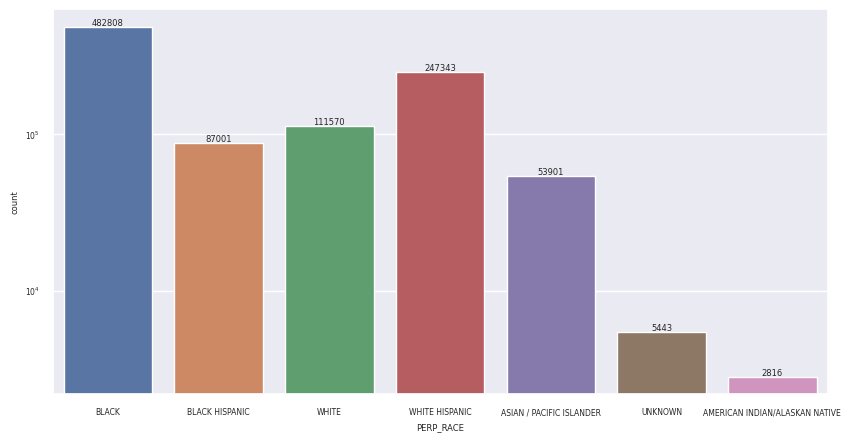

In [ ]:
# Mostrar cantidad de crímenes:
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.5)
g = sns.countplot(data = data_hist, x = "PERP_RACE")
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

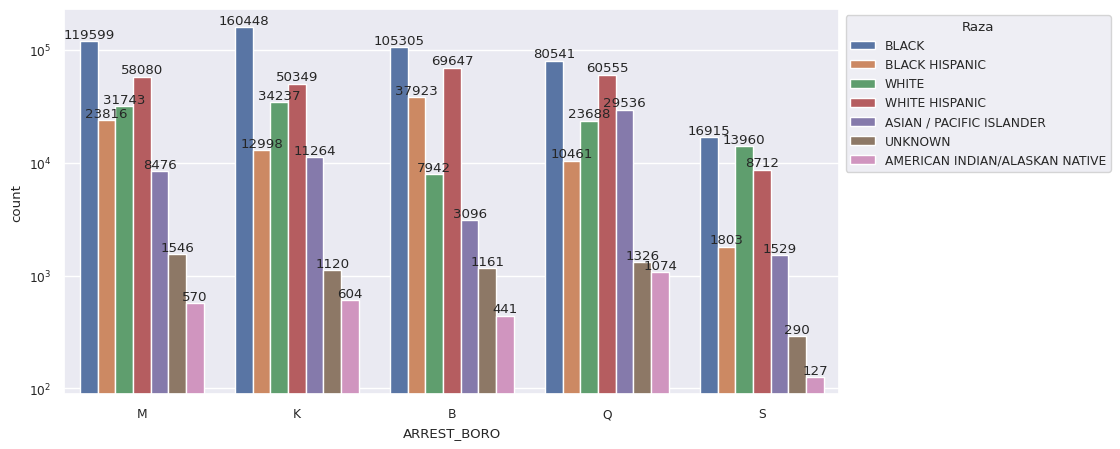

In [ ]:
# Mostrar cantidad de crímenes (Distrito):
sns.set(rc = {'figure.figsize':(10, 5)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, x = "ARREST_BORO", hue = "PERP_RACE")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Raza')
plt.yscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

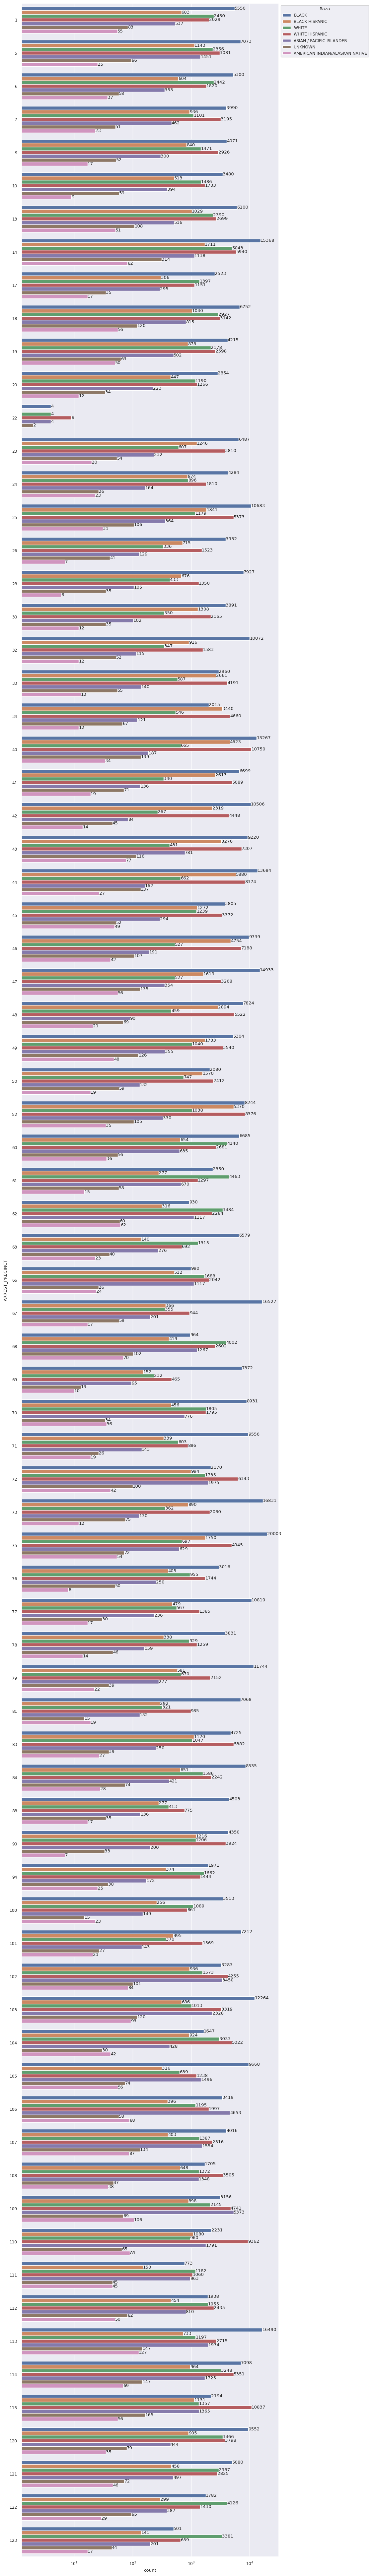

In [ ]:
# Mostrar cantidad de crímenes (Comisaría):
sns.set(rc = {'figure.figsize':(10, 100)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "ARREST_PRECINCT", hue = "PERP_RACE")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Raza')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

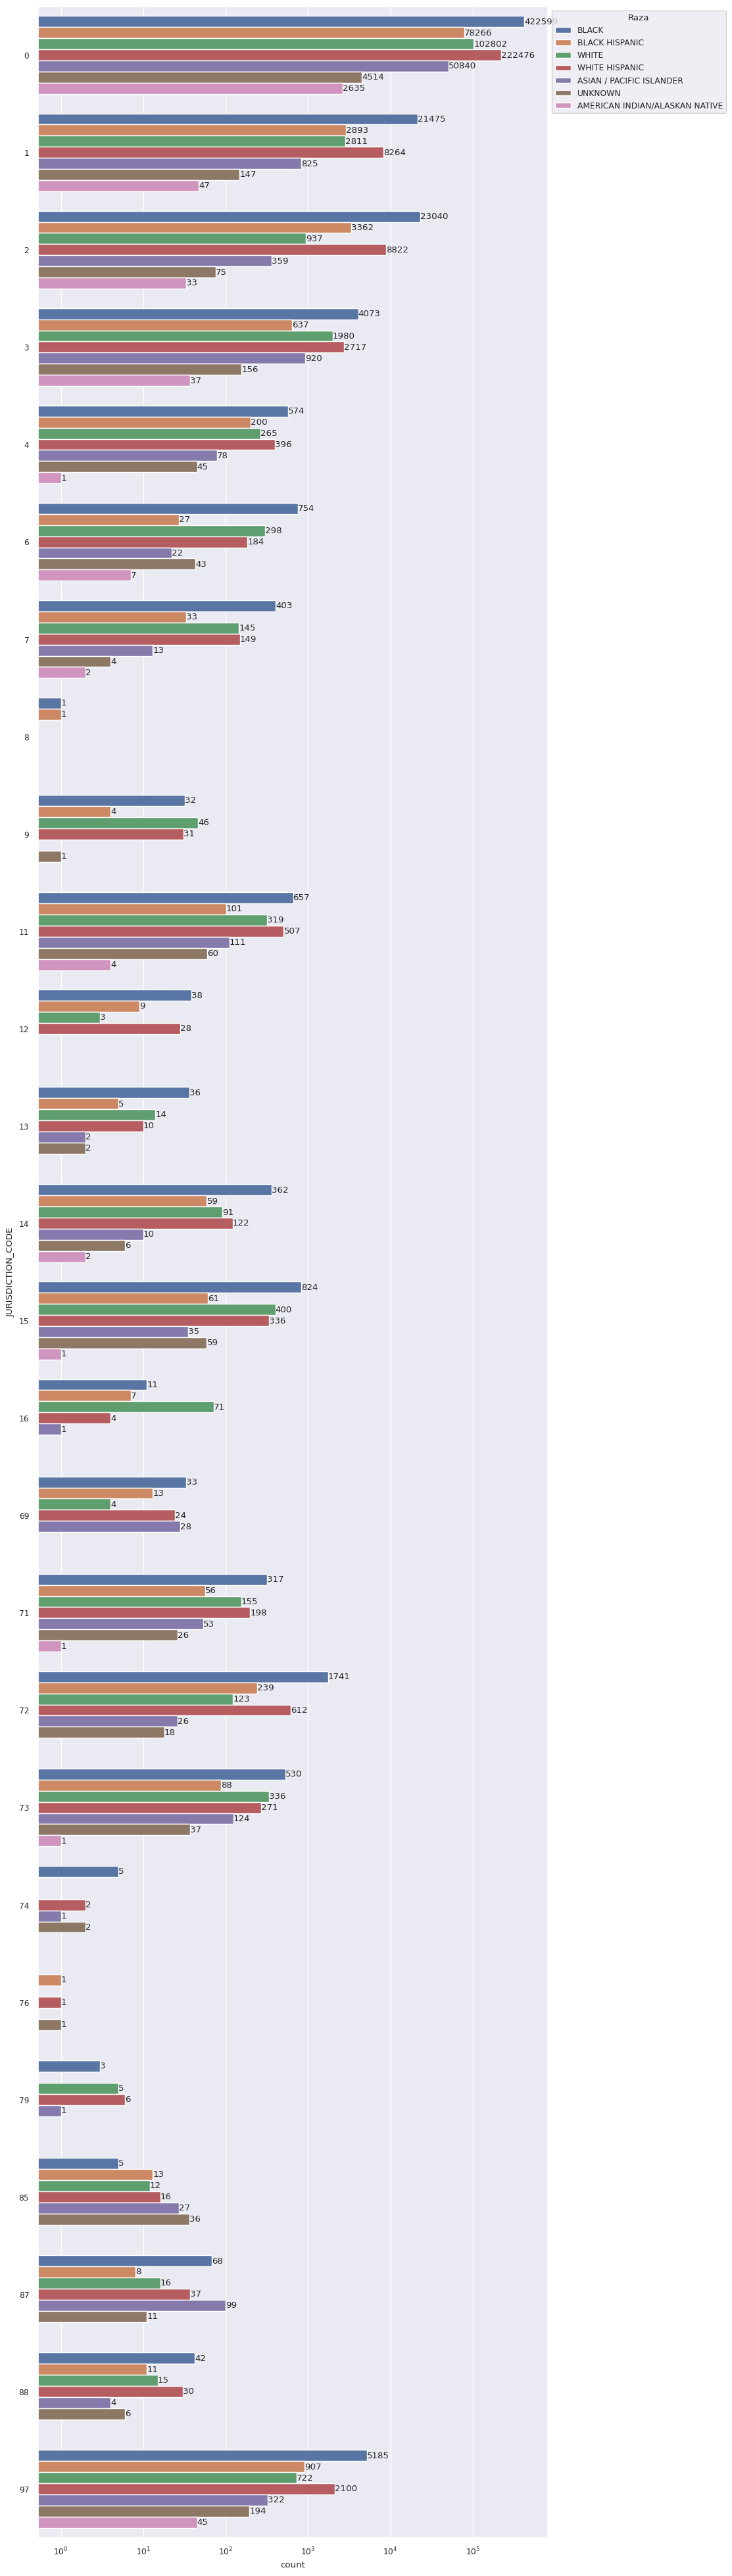

In [ ]:
# Mostrar cantidad de crímenes (Jurisdicción):
sns.set(rc = {'figure.figsize':(10, 50)}, font_scale = 0.8)
g = sns.countplot(data = data_hist, y = "JURISDICTION_CODE", hue = "PERP_RACE")
g.legend(loc = 'upper left', bbox_to_anchor = (1, 1), title = 'Raza')
plt.xscale('log')

for container in g.containers:
    g.bar_label(container)

plt.show()

# [Pregunta 11] Mapa de mayor reporte de crímenes:

In [ ]:
# Crear DataFrame para graficar:
data_hist = pd.concat([df_2018_2022, df_2023]).sample(n = 10000)
data_hist = pd.DataFrame(data_hist[["Latitude", "Longitude"]])

In [ ]:
# Crear mapa:
map_heat = folium.Map(location = [40.7, -74], zoom_start = 10.5, tiles='stamentoner')
HeatMap(list(zip(data_hist["Latitude"].tolist(), data_hist["Longitude"].tolist())), min_opacity = 0.2, blur = 15).add_to(map_heat)

map_heat

# SetUp del modelo predictivo:

##Datos de prueba:

In [ ]:
# Crear DataFrame:
df_total = pd.concat([df_2018_2022, df_2023]).drop(["PD_DESC", "LAW_CAT_CD", "Lon_Lat", "New Georeferenced Column"], axis = 1)
df_total = df_total.dropna()
df_total = df_total.sample(n=10000)
df_total = df_total.groupby("OFNS_DESC").filter(lambda x : len(x)>10)
df_total

# Tamaño de gráficas:
sns.set(rc = {'figure.figsize':(6, 3)}, font_scale = 0.8)

In [ ]:
# Crear diccionario con valores "OFNS_DESC" de x:
list_x_OFNSDesc = pd.DataFrame({"OFNS_DESC": df_total.OFNS_DESC.unique()})
list_x_OFNSDesc['ID_OFNS_Desc'] = np.arange(len(list_x_OFNSDesc))
list_x_OFNSDesc = dict(list_x_OFNSDesc.values)
# Crear diccionario con valores "ARREST_DATE" de x:
list_x_ArrestDate = pd.DataFrame({"ARREST_DATE": df_total.ARREST_DATE.unique()})
list_x_ArrestDate['ID_Arrest_Date'] = np.arange(len(list_x_ArrestDate))
list_x_ArrestDate = dict(list_x_ArrestDate.values)
# Crear diccionario con valores "LAW_CODE" de x:
list_x_LawCode = pd.DataFrame({"LAW_CODE": df_total.LAW_CODE.unique()})
list_x_LawCode['ID_Law_Code'] = np.arange(len(list_x_LawCode))
list_x_LawCode = dict(list_x_LawCode.values)
# Crear diccionario con valores "ARREST_BORO" de x:
list_x_ArrestBoro = pd.DataFrame({"ARREST_BORO": df_total.ARREST_BORO.unique()})
list_x_ArrestBoro['ID_Arrest_Boro'] = np.arange(len(list_x_ArrestBoro))
list_x_ArrestBoro = dict(list_x_ArrestBoro.values)
# Crear diccionario con valores "AGE_GROUP" de x:
list_x_AgeGroup = pd.DataFrame({"AGE_GROUP": df_total.AGE_GROUP.unique()})
list_x_AgeGroup['ID_Age_Group'] = np.arange(len(list_x_AgeGroup))
list_x_AgeGroup = dict(list_x_AgeGroup.values)
# Crear diccionario con valores "PERP_SEX" de x:
list_x_PerpSex = pd.DataFrame({"PERP_SEX": df_total.PERP_SEX.unique()})
list_x_PerpSex['ID_Perp_Sex'] = np.arange(len(list_x_PerpSex))
list_x_PerpSex = dict(list_x_PerpSex.values)
# Crear diccionario con valores "PERP_RACE" de x:
list_x_PerpRace = pd.DataFrame({"PERP_RACE": df_total.PERP_RACE.unique()})
list_x_PerpRace['ID_Perp_Race'] = np.arange(len(list_x_PerpRace))
list_x_PerpRace = dict(list_x_PerpRace.values)
# Reemplazar todos los valores con los diccionarios:
df_total = df_total.replace({"OFNS_DESC":list_x_OFNSDesc, "ARREST_DATE":list_x_ArrestDate, "LAW_CODE":list_x_LawCode, "ARREST_BORO":list_x_ArrestBoro, "AGE_GROUP":list_x_AgeGroup, "PERP_SEX":list_x_PerpSex, "PERP_RACE":list_x_PerpRace})

In [ ]:
# Inputs:
x = df_total.drop(["OFNS_DESC"], axis = 1).reset_index()
x = x.drop("index", axis = 1)
x

ARREST_KEY  ARREST_DATE   PD_CD   KY_CD  LAW_CODE  ARREST_BORO  \
0      192451053            0 922.000 348.000         0            0   
1      247115820            1 750.000 359.000         1            1   
2      198194369            2 101.000 344.000         2            2   
3      186912758            3 511.000 235.000         3            3   
4      188539715            4 109.000 106.000         4            0   
...          ...          ...     ...     ...       ...          ...   
9918   227676529         1698 441.000 110.000       121            1   
9919   251650634          290 268.000 121.000        29            0   
9920   192941318          272 514.000 117.000       151            2   
9921   253071261          785 759.000 359.000        50            0   
9922   175012387          165 848.000 364.000       204            3   

      ARREST_PRECINCT  JURISDICTION_CODE  AGE_GROUP  PERP_SEX  PERP_RACE  \
0                  73                  0          0         0          0   
1                  40                  0          1         0          1   
2                 110                  0          2         1          2   
3                  25                 97          0         0          3   
4                  68                  0          1         0          3   
...               ...                ...        ...       ...        ...   
9918               47                  0          0         0          2   
9919               78                  0          2         1          0   
9920              104                  0          2         0          2   
9921               73                  1          2         0          0   
9922               23                  0          3         0          0   

      X_COORD_CD  Y_COORD_CD  Latitude  Longitude  Zip Codes  \
0        1007966      183068    40.669    -73.915  17614.000   
1        1008239      235709    40.814    -73.913  10933.000   
2        1023569      211154    40.746    -73.858  14510.000   
3        1004138      226326    40.788    -73.928  13093.000   
4         978016      171958    40.639    -74.022  18180.000   
...          ...         ...       ...        ...        ...   
9918     1029929      259221    40.878    -73.835  12344.000   
9919      989249      180622    40.662    -73.982  17617.000   
9920     1013749      204160    40.727    -73.894  14788.000   
9921     1010774      185570    40.676    -73.904  13516.000   
9922      999562      229195    40.796    -73.945  12426.000   

      Community Districts  Borough Boundaries  City Council Districts  \
0                  55.000               2.000                  17.000   
1                  49.000               5.000                  35.000   
2                  66.000               3.000                  21.000   
3                   7.000               4.000                  35.000   
4                  10.000               2.000                   7.000   
...                   ...                 ...                     ...   
9918               29.000               5.000                   2.000   
9919               14.000               2.000                  27.000   
9920               54.000               3.000                  34.000   
9921               55.000               2.000                  37.000   
9922                7.000               4.000                  35.000   

      Police Precincts  
0               46.000  
1               23.000  
2               68.000  
3               16.000  
4               41.000  
...                ...  
9918            30.000  
9919            50.000  
9920            62.000  
9921            46.000  
9922            14.000  

[9923 rows x 20 columns]

In [ ]:
# Outputs:
y = pd.DataFrame(df_total["OFNS_DESC"]).reset_index()
y = y.drop("index", axis = 1)
y

OFNS_DESC
0             0
1             1
2             2
3             3
4             4
...         ...
9918         40
9919         12
9920          3
9921          1
9922         37

[9923 rows x 1 columns]

## Extracción:

In [ ]:
# 25% DE PRUEBA / 75% DE ENTRENAMIENTO
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

print("Inputs:", len(x_train), len(x_test))
print("Outputs:", len(y_train), len(y_test))

Inputs: 7442 2481
Outputs: 7442 2481


##Funciones:

In [ ]:
def modelo_clasificacion (modelo, x_train, y_train, x_test, y_test):
  
  m = modelo.fit(x_train, y_train)
  score_train = round(m.score(x_train, y_train) * 100, 2)
  score_test = round(m.score(x_test, y_test) *100, 2)
  cm = confusion_matrix(y_test, m.predict(x_test), labels = m.classes_)
  ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = m.classes_).plot()
  print(classification_report(y_test, m.predict(x_test), labels = m.classes_))

  return score_train, score_test

In [ ]:
def validacion_cruzada (modelo, x, y, metrica):

  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
  n_scores= cross_val_score(modelo, x, y, scoring = metrica, cv = cv, n_jobs = -1)
  media = np.mean(n_scores)
  COV = np.std(n_scores)/np.mean(n_scores)*100
  plt.plot(np.arange(1,len(n_scores)+1), n_scores, "o-", label = str(modelo))
  plt.axhline(media, color = "r", linestyle = "--")
  plt.legend(bbox_to_anchor=(1, 1))
  
  return media, COV

#Modelos de clasificación:

##Regresión logística:

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.00      0.00      0.00        60
           2       0.17      0.93      0.28       402
           3       0.19      0.18      0.19       217
           4       0.09      0.00      0.01       217
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00       136
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00       233
           9       0.00      0.00      0.00        48
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00       118
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        35
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(15.84, 16.73)

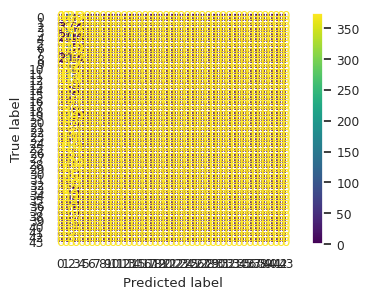

In [ ]:
modelo_clasificacion(LogisticRegression(), x_train, y_train, x_test, y_test)

(0.00896177223999928, 10.065120609002982)

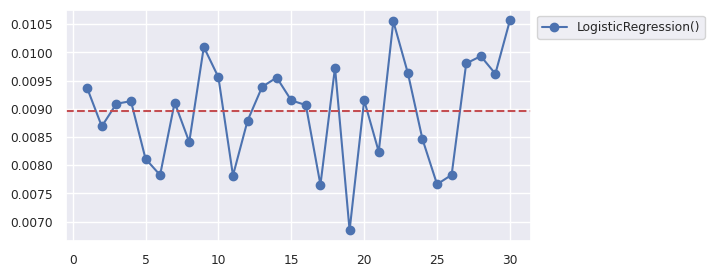

In [ ]:
validacion_cruzada(LogisticRegression(), x, y, "f1_macro")

##KNN:

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


              precision    recall  f1-score   support

           0       0.06      0.18      0.09       148
           1       0.02      0.05      0.03        60
           2       0.16      0.32      0.22       402
           3       0.10      0.15      0.12       217
           4       0.07      0.07      0.07       217
           5       0.00      0.00      0.00         8
           6       0.06      0.04      0.05       136
           7       0.25      0.04      0.07        24
           8       0.11      0.09      0.10       233
           9       0.00      0.00      0.00        48
          10       0.03      0.02      0.02        61
          11       0.03      0.02      0.02       118
          12       0.07      0.02      0.03       118
          13       0.07      0.03      0.04        37
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        35
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(32.8, 9.88)

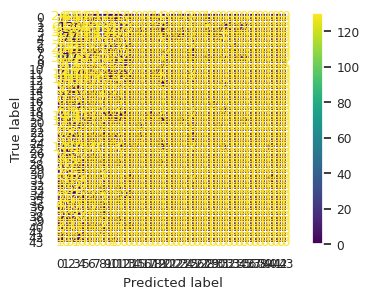

In [ ]:
modelo_clasificacion(KNeighborsClassifier(), x_train, y_train, x_test, y_test)

(0.02854376306202012, 30.231326803946075)

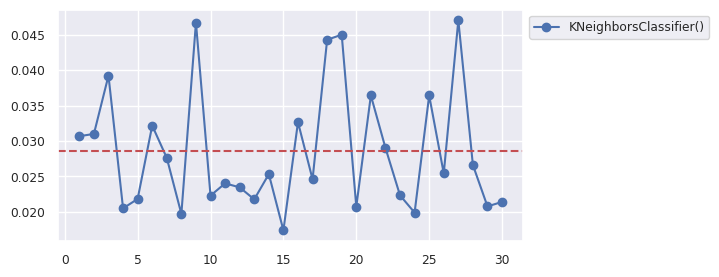

In [ ]:
validacion_cruzada(KNeighborsClassifier(), x, y, "f1_macro")

##Naive Bayes Gaussian:

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.01      0.03       148
           1       0.00      0.00      0.00        60
           2       0.24      0.80      0.37       402
           3       0.16      0.35      0.22       217
           4       0.00      0.00      0.00       217
           5       0.00      0.00      0.00         8
           6       0.10      0.14      0.11       136
           7       0.00      0.00      0.00        24
           8       0.19      0.33      0.24       233
           9       0.00      0.00      0.00        48
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00       118
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        35
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(20.38, 20.19)

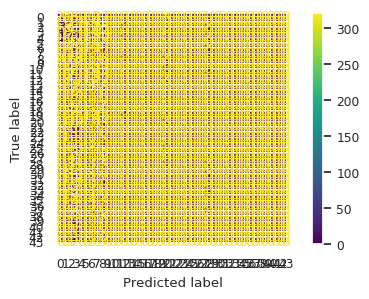

In [ ]:
modelo_clasificacion(GaussianNB(), x_train, y_train, x_test, y_test)

(0.027034488042410022, 21.504514918126336)

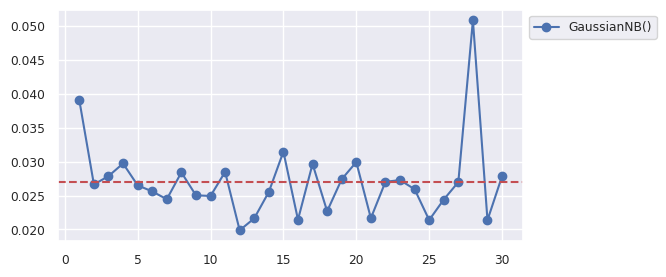

In [ ]:
validacion_cruzada(GaussianNB(), x, y, "f1_macro")

##Naive Bayes Bernoulli

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       1.00      0.52      0.68       148
           1       0.00      0.00      0.00        60
           2       0.17      0.99      0.29       402
           3       0.06      0.01      0.02       217
           4       0.00      0.00      0.00       217
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00       136
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00       233
           9       0.00      0.00      0.00        48
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00       118
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        35
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(18.81, 19.35)

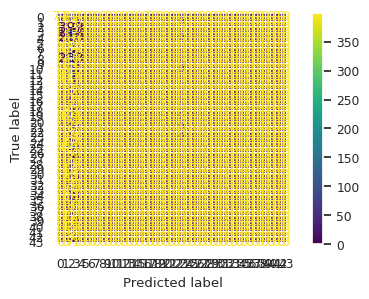

In [ ]:
modelo_clasificacion(BernoulliNB(), x_train, y_train, x_test, y_test)

(0.02499428674804325, 7.2930052083033425)

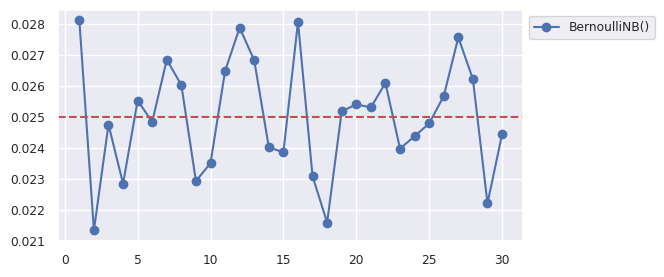

In [ ]:
validacion_cruzada(BernoulliNB(), x, y, "f1_macro")

##Desicion Tree Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       148
           1       1.00      0.98      0.99        60
           2       1.00      1.00      1.00       402
           3       1.00      1.00      1.00       217
           4       1.00      1.00      1.00       217
           5       1.00      1.00      1.00         8
           6       0.99      1.00      1.00       136
           7       0.96      1.00      0.98        24
           8       1.00      1.00      1.00       233
           9       1.00      0.98      0.99        48
          10       1.00      1.00      1.00        61
          11       1.00      1.00      1.00       118
          12       0.98      0.99      0.99       118
          13       1.00      1.00      1.00        37
          14       0.75      1.00      0.86         6
          15       1.00      1.00      1.00        35
          16       1.00      1.00      1.00         2
          17       1.00    

(100.0, 99.6)

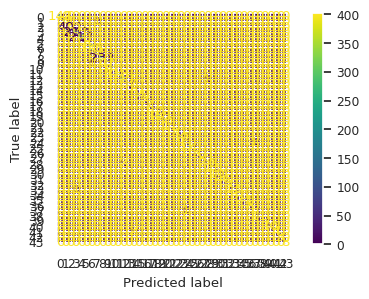

In [ ]:
modelo_clasificacion(DecisionTreeClassifier(), x_train, y_train, x_test, y_test)

(0.9780365345979448, 1.3220742114108752)

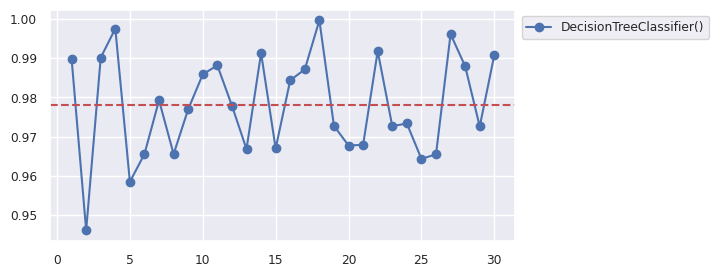

In [ ]:
validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro")

##Random Forest:

<ipython-input-95-90ba33eaca80>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = modelo.fit(x_train, y_train)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       148
           1       0.97      1.00      0.98        60
           2       1.00      1.00      1.00       402
           3       0.95      1.00      0.97       217
           4       1.00      1.00      1.00       217
           5       0.89      1.00      0.94         8
           6       0.92      0.93      0.93       136
           7       0.84      0.88      0.86        24
           8       1.00      1.00      1.00       233
           9       1.00      0.85      0.92        48
          10       1.00      1.00      1.00        61
          11       0.99      1.00      1.00       118
          12       0.98      0.96      0.97       118
          13       0.97      0.97      0.97        37
          14       0.71      0.83      0.77         6
          15       0.94      0.91      0.93        35
          16       1.00      1.00      1.00         2
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(100.0, 96.78)

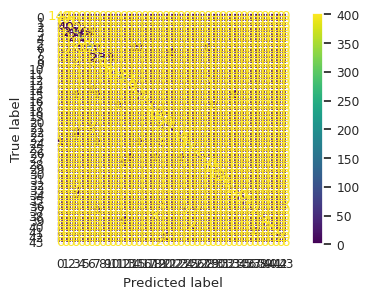

In [ ]:
modelo_clasificacion(RandomForestClassifier(), x_train, y_train, x_test, y_test)

(0.8729932176246251, 4.286976585488233)

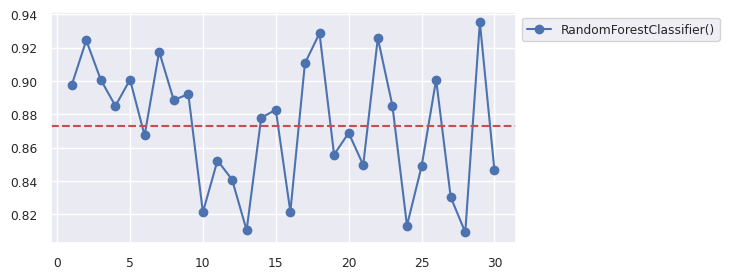

In [ ]:
validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro")

##Extra Trees Classifier:

<ipython-input-95-90ba33eaca80>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m = modelo.fit(x_train, y_train)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       148
           1       0.78      1.00      0.88        60
           2       1.00      1.00      1.00       402
           3       0.94      1.00      0.97       217
           4       0.99      1.00      0.99       217
           5       1.00      1.00      1.00         8
           6       0.96      0.97      0.96       136
           7       0.92      0.46      0.61        24
           8       1.00      1.00      1.00       233
           9       0.96      0.92      0.94        48
          10       1.00      1.00      1.00        61
          11       1.00      1.00      1.00       118
          12       0.86      0.93      0.89       118
          13       1.00      0.92      0.96        37
          14       1.00      0.17      0.29         6
          15       0.83      1.00      0.91        35
          16       1.00      0.50      0.67         2
          17       1.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(100.0, 95.53)

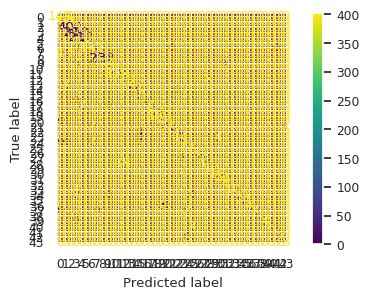

In [ ]:
modelo_clasificacion(ExtraTreesClassifier(), x_train, y_train, x_test, y_test)

(0.8587336271457728, 3.8741415304813924)

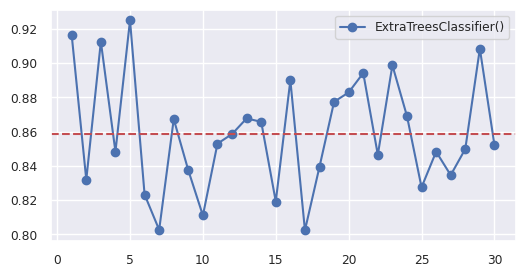

In [ ]:
validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro")

##Multilayer Perceptron Classifier:

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       148
           1       0.00      0.00      0.00        60
           2       0.16      1.00      0.28       402
           3       0.00      0.00      0.00       217
           4       0.00      0.00      0.00       217
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00       136
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00       233
           9       0.00      0.00      0.00        48
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00       118
          12       0.00      0.00      0.00       118
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         6
          15       0.00      0.00      0.00        35
          16       0.00      0.00      0.00         2
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(15.64, 16.2)

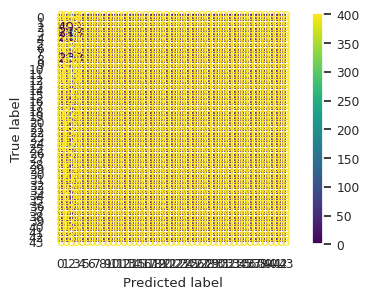

In [ ]:
modelo_clasificacion(MLPClassifier(), x_train, y_train, x_test, y_test)

(0.002762048367736544, 63.37509721954435)

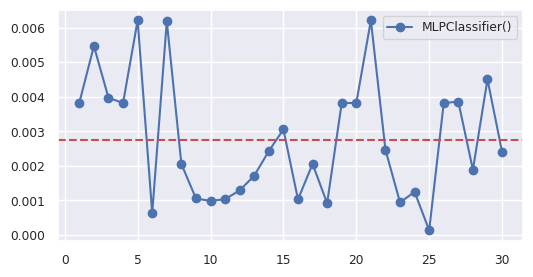

In [ ]:
validacion_cruzada(MLPClassifier(), x, y, "f1_macro")

# Comparación:

Model  f1_score_macro  COV [%]
4    Decision Classifier           0.981    1.333
5          Random Forest           0.869    3.328
6  Extra Tree Classifier           0.863    4.041
1                    KNN           0.027   24.639
2   Naive Bayes Gaussian           0.027   17.741
3  Naive Bayes Bernoulli           0.026    7.206
0   Logistic Regression            0.009   11.820
7         MLP Classifier           0.004   55.337

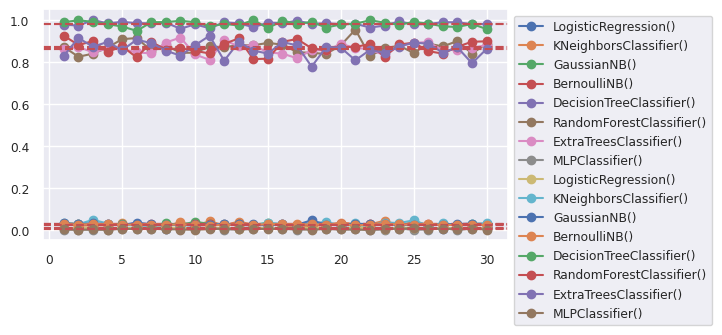

In [ ]:
# Se eliminaron los modelos con "SVC" y con "XGBClassifier", porque daban errores.
models = pd.DataFrame({
  'Model': ["Logistic Regression ",
    "KNN",
    "Naive Bayes Gaussian",
    "Naive Bayes Bernoulli",
    "Decision Classifier",
    "Random Forest",
    "Extra Tree Classifier",
    "MLP Classifier"],

  'f1_score_macro': [validacion_cruzada(LogisticRegression(), x, y, "f1_macro")[0],
    validacion_cruzada(KNeighborsClassifier(), x, y, "f1_macro")[0],
    validacion_cruzada(GaussianNB(), x, y, "f1_macro")[0],
    validacion_cruzada(BernoulliNB(), x, y, "f1_macro")[0],
    validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro")[0],
    validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro")[0],
    validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro")[0],
    validacion_cruzada(MLPClassifier(), x, y, "f1_macro")[0]],

  'COV [%]': [validacion_cruzada(LogisticRegression(), x, y, "f1_macro")[1],
    validacion_cruzada(KNeighborsClassifier(), x, y, "f1_macro")[1],
    validacion_cruzada(GaussianNB(), x, y, "f1_macro")[1],
    validacion_cruzada(BernoulliNB(), x, y, "f1_macro")[1],
    validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro")[1],
    validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro")[1],
    validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro")[1],
    validacion_cruzada(MLPClassifier(), x, y, "f1_macro")[1]]})

models.sort_values(by = 'f1_score_macro', ascending = False)

# Antes de Optimizar:
Modelo predictivo seleccionado: (DesicionTreeClassifier)

[(0.9785691207086503, 1.2352208070576864),
 (0.8662100968685135, 2.6338817090559163),
 (0.8546950915086969, 3.997039245052979)]

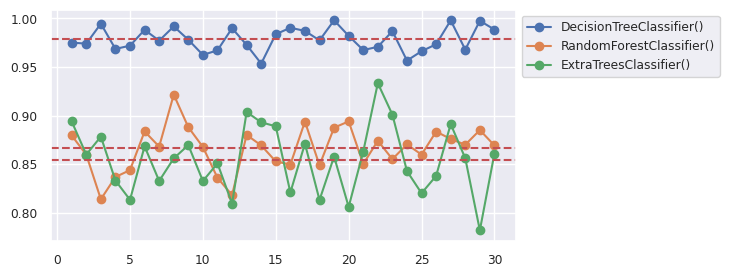

In [ ]:
# Para buscar el mejor desempeño, se utilizan el mejor modelo: "DesicionTreeClassifier"
# Se muestra una comparación con los otros dos mejores modelos
pre_tuning = []

pre_tuning.append(validacion_cruzada(DecisionTreeClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(RandomForestClassifier(), x, y, "f1_macro"))
pre_tuning.append(validacion_cruzada(ExtraTreesClassifier(), x, y, "f1_macro"))

pre_tuning

# Optimización:
Hiperparametros: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 100, 'min_samples_leaf': 2}

In [ ]:
# Función de Sintonización: (Al final se muestran los hiperparámetros finales)

def op_DT (trial):
  _criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
  _splitter = trial.suggest_categorical("splitter", ["best", "random"])
  _max_depth = trial.suggest_categorical("max_depth", [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
  _min_samples_leaf = trial.suggest_categorical("min_samples_leaf", [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

  model = DecisionTreeClassifier(criterion = _criterion,
                                 splitter = _splitter,
                                 max_depth = _max_depth,
                                 min_samples_leaf = _min_samples_leaf)
  
  cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)

  return cross_val_score(model, x, y, scoring = "f1_macro", cv = cv, n_jobs = -1).mean()

study_DT = optuna.create_study(direction = "maximize")
study_DT.optimize(op_DT, n_trials = 30)

trial = study_DT.best_trial

print("Score:" ,format(trial.value))
print("Hiperparametros:" ,format(trial.params))

[I 2023-05-30 00:56:50,285] A new study created in memory with name: no-name-14a1b755-bd41-4f95-bc51-70cdffa08d20
[I 2023-05-30 00:56:52,296] Trial 0 finished with value: 0.9602226608358599 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 60, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9602226608358599.
[I 2023-05-30 00:56:55,630] Trial 1 finished with value: 0.44930094974834284 and parameters: {'criterion': 'entropy', 'splitter': 'best', 'max_depth': 5, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9602226608358599.
[I 2023-05-30 00:56:56,469] Trial 2 finished with value: 0.9688674342267934 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 100, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9688674342267934.
[I 2023-05-30 00:56:59,225] Trial 3 finished with value: 0.9573737801352152 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 40, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.968

Score: 0.9805305351233077
Hiperparametros: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 100, 'min_samples_leaf': 2}


In [ ]:
# Desarrollo de la optimización 
optuna.visualization.plot_optimization_history(study_DT)

In [ ]:
# Importancia de las hiperparámetros (Significancia/Relevancia)
optuna.visualization.plot_param_importances(study_DT)

[(0.9744484349576699, 1.809386099939684)]

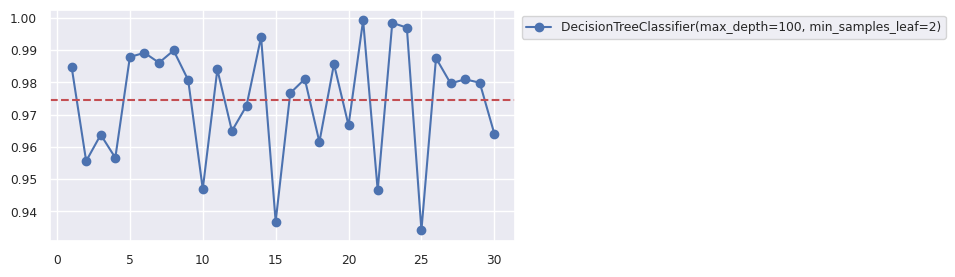

In [ ]:
# Valores de desempeño post-tuning (Muestra final)
post_tuning = []

_criterion_DT = trial.params["criterion"]
_splitter_DT = trial.params["splitter"]
_max_depth_DT = trial.params["max_depth"]
_min_samples_leaf_DT = trial.params["min_samples_leaf"]

post_tuning.append(validacion_cruzada(DecisionTreeClassifier(criterion = _criterion_DT,
                                                             splitter = _splitter_DT,
                                                             max_depth = _max_depth_DT,
                                                             min_samples_leaf = _min_samples_leaf_DT),
                                                             x, y, "f1_macro"))

post_tuning